# <img src="uni-logo.png" alt="Logo UNI" width=100 hight=200 align="right">


<br><br><br>
<h1><font color="#7F000E" size=5>Sistemas Inteligentes</font></h1>
<h1><font color="#7F000E" size=4>Capstone II</font></h1>

Por:
<ul>
    <li>Tejada Villagaray, Luis Enrique</li>
</ul>
</font>

<h1><font color="#7F000E" size=3>Machine Learning aplicado al Marketing</font></h1>

<br>
<div style="text-align: right">
<font color="#7F000E" size=3>Facultad de Ciencias</font><br>
<font color="#7F000E" size=3>Maestria en Ciencia de la Computación</font><br>
</div>



<h2><font color="#7F000E" size=5>Introducción</font></h2>
<br>




En este proyecto se plantean tres supuestos que guardan relación con el área del márketing y la gestión de la relación con el cliente (_Customer Relationship Management_). El primero consiste en el desarrollo de un *pipeline* completo para la predicción del abandono  de clientes (_Churn prevention_).  En el segundo se desarrollará un modelo que permite estimar el valor potencial de un cliente (_Customer Lifetime Value_). Por último, se recurrirá al aprendizaje no supervisado para segmentar un conjunto de clientes en grupos.


A diferencia de los proyectos anteriores, que consistían exclusivamente en la solución de ejercicios prácticos, en éste se plantearan también algunas preguntas relacionadas con la interpretación y análisis del proceso, y que habrán de ser respondidas en la propia libreta. 
<br>



---

<a id="indice"></a>
<h2><font color="#7F000E" size=5>Índice</font></h2>


* [1. Prevención del abandono (_churn prevention_)](#section1)
    * [1.1. Exploración de los datos. Preprocesamiento](#section11) 
    * [1.2. Construcción de un modelo](#section12)     
    * [1.3. Validación sobre nuevos datos](#section13)  
    * [1.4. Comparación con otros modelos](#section14)  
* [2. Predicción del valor potencial de un cliente (_Customer Lifetime Value_)](#section2) 
    * [2.1. Construcción de un árbol de regresión](#section21)  
* [3. Segmentación de clientes](#section3) 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Es necesario utilizar la versión `0.20` o posterior de `scikit-learn`.
</div>

In [2]:
#!pip install --upgrade scikit-learn==0.23.2

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#7F000E"></i></font></a>
</div>

---

<a id="section1"></a>
# <font color="#7F000E"> 1. Prevención del abandono (_churn prevention_)</font>


<br> La prevención del abandono, o _Churn prevention_, es una tarea de _márketing_ que consiste en detectar 
aquellos clientes que podrían abandonar un determinado servicio o mercado, y llevar a cabo campañas específicas de retención con el fin de evitar la pérdida. 
<br>

Esta parte del proyecto consiste en la elaboración de un modelo basado en aprendizaje supervisado (clasificación) para la detección de clientes en esta situación. Se proporciona un conjunto de datos denominado `Telco-Customer-Churn.csv`, relativo al abandono en una operadora de telecomunicaciones, y obtenido en el sitio de [IBM analytics](https://www.ibm.com/analytics). Alguna información adicional, así como _kernels_ que tratan estos mismos datos y pueden resultar útiles (_se recomienda que los miréis_) están disponibles en [kaggle](https://www.kaggle.com/blastchar/telco-customer-churn). 

In [3]:
# Carga los datos 
df_churn = pd.read_csv('data/churn/Telco-Customer-Churn.csv', index_col=0);

print("Tamaño del conjunto de datos:  %d" % df_churn.shape[0])
print("Número de variables: %d" % df_churn.shape[1])
if df_churn.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')
    
# Visualiza las primeras instancias
df_churn.head()

Tamaño del conjunto de datos:  7043
Número de variables: 20
El índice es único.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Como línea de trabajo, se asumirá que el modelo se desarrollará a partir de un conjunto manejable de datos etiquetados (histórico), pero será utilizado sobre un conjunto de datos actual, no etiquetado, y mucho mayor. Debido a esto, se dividirá el conjunto de datos almacenado en `df_churn` en dos: `df_churn` con el 85% de las entradas, y que será utilizado en el proceso de desarrollo (y validación) del modelo; y `df_churn_new`, con el 15% restante, que permitirá tanto comprobar la correcta definición del flujo de trabajo sobre datos nuevos, como proporcionar medidas de rendimiento del modelo. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> El conjunto de datos `df_churn_new` __no será utilizado en ninguna fase del proceso de aprendizaje__, ni siquiera para la exploración, preprocesamiento, o la validación del modelo.
</div>

In [4]:
# Tamaño del conjunto de entrenamiento
training_size = int(len(df_churn)*0.85)

# Desordena los datos (esto es muy importante).
df_churn = df_churn.sample(frac=1, random_state=0)

# Copia los datos de test.
df_churn_new = df_churn.iloc[training_size:].copy()
# Copia los datos para el entrenamiento del modelo.
df_churn = df_churn.iloc[:training_size].copy()

print("Tamaño del conjunto de datos disponibles: ", len(df_churn))
print("Tamaño del conjunto de nuevos datos: ", len(df_churn_new))

Tamaño del conjunto de datos disponibles:  5986
Tamaño del conjunto de nuevos datos:  1057


En ciencia de datos es frecuente que el punto de partida del trabajo lo constituyan datos desconocidos. El primer paso, *también cuando se trabaja con aprendizaje automático*, consiste en **explorar estos datos**. Además de la familiarización con el problema (que no siempre es posible), como fruto de la exploración surgen decisiones que afectan _principalmente_ a la preparación y al preprocesamiento. 
<br>

En general, el proceso de exploración no es sistemático, sino que se lleva a cabo en base a los datos que el propio proceso va arrojando, y es guiado en parte por la intuición y experiencia del analista. En cada paso, surge la necesidad de hacer transformaciones a los datos originales de cara a su uso en la construción del modelo predictivo. Estos cambios pueden ir haciéndose progresivamente. Sin embargo, ***todo el proceso ha de ser registrado de algún modo, ya que ha de ser reproducido para el tratamiento de nuevos datos*** que, en un contexto real, se supone que son adquiridos con el formato del conjunto de datos original.
<br>

A lo largo del módulo se ha estudiado como hacer _pipelines_ o secuencias de funciones en `scikit-learn`. Aunque _esta funcionalidad es muy útil_, incorporar todo el proceso de los datos dentro de un _pipeline_ puede ser tedioso, e incluso puede haber limitaciones que lo impidan o hagan recomendable un modo alternativo de trabajo. En realidad, _es posible apartar (y anticipar) algunas tareas de preparación de datos_ del proceso definido en el _pipeline_ de `scikit-learn`. Así, operaciones como la eliminación o transformación de columnas, cuya aplicación en nuevos datos es _totalmente independiente del entrenamiento_,  pueden llevarse a cabo mediante una función previa a la construcción del modelo (y repetirse previamente a su uso).
<br>

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> Ejemplos de operaciones que dependen del entrenamiento son la estándarización o la sustitución de valores perdidos por la media/mediana. Éstas sí deben formar parte del *pipeline* de `scikit-learn` ya que implican instanciar un transformador.
</div>

En este proyecto se propone un modo de trabajar en el que sucesivamente, _durante la exploración_, se aplicarán funciones de preprocesamiento a un _DataFrame_. Estas funciones serán almacenadas en una lista que, finalmente, podrá ser utilizada para la reproducción de la secuencia de preprocesamiento sobre nuevos datos. Una vez disponible una versión adecuada de los datos, el trabajo con `scikit-learn` se hará según el procedimiento habitual.


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: El modo de trabajo que se propone __no es el único, pero es una alternativa__ que puede ser conveniente en algunos supuestos, y distinta a las vistas en clase (implementación de transformadores). Por otra parte, esta tarea  se centra en la construcción de modelos, por lo que __la parte de exploración se ha reducido al mínimo imprescindible__. No obstante, podéis incluir pasos adicionales en este sentido si lo veis conveniente.
</div>

Considerando el planteamiento descrito, es necesario registrar las transformaciones que se irán haciendo sobre el *DataFrame* y el tratamiento que se hará finalmente a cada variable dentro del *pipeline* de `scikit-learn`. Para ello, se utilizarán tres listas:

* `churn_data_prep_pipeline`, que guardará la secuencia de funciones de transformación (referencias) aplicadas al _DataFrame_.

* `cat_features`, que guardará los nombres de las columnas que contienen valores discretos, y que han de ser tratadas  como categóricas.

* `num_features`, que guardará los nombres de las columnas que han de ser tratadas como numéricas.

In [5]:
# Lista de funciones aplicadas en la preparación de los datos

churn_data_prep_pipeline = []

# Características que serán consideradas categóricas y numéricas en el pipeline
cat_features = []
num_features = []

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#7F000E"></i></font></a>
</div>

---

<a id="section11"></a>
## <font color="#7F000E"> 1.1 Exploración de los datos. Preprocesamiento. </font>
<br>


El objetivo principal de este trabajo es predecir la baja de un determinado usuario mediante un modelo de clasificación. Por eso, uno de los pasos más importantes en la exploración consiste en el análisis e interpretación de la distribución de las clases. Este factor puede resultar de interés en el entrenamiento, pero también de cara a la evaluación. 

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 1 </font> 
Dibujar un diagrama de barras (`sns.catplot()` o `sns.countplot()`) con la distribución de las clases (columna `Churn`) sobre las muestras. Obtener los posibles valores de las mismas. Comentar qué se aprecia en la gráfica, en qué modo puede afectar esto al rendimiento del clasificador, y si esto influye en el modo en que se ha de llevar a cabo la evaluación. 

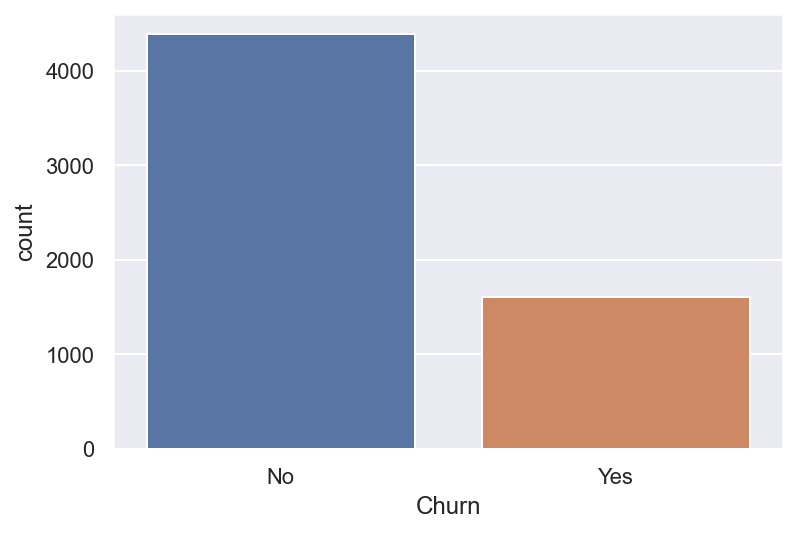

Clases:  ['No' 'Yes']
El porcentaje de muestras positivas es 0.27


In [6]:
sns.countplot(x = 'Churn', data = df_churn)
plt.show()

print("Clases: ", df_churn['Churn'].unique())
print(f"El porcentaje de muestras positivas es {(sum(df_churn['Churn']=='Yes') / df_churn.shape[0]):.2f}")

___Respuesta:___

El diagrama muestra el conteo de observaciones de clientes que han decidido abandonar (Churn), nos muestra que hay un desbalance en nuestros datos, ya que la variable Churn no está igualmente distribuida en nuestra clase. De modo más concreto, NO 73% y SI 27%, al tener un desbalance tan pronunciado puede influir en tener falsos negativos si no se realiza un tratamiento para equilibrar ambos valores.

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

Puede apreciarse que las clases están codificadas como _Strings_. Para trabajar con `scikit-learn` se necesita convertirlas a formato numérico.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
Este paso no será incluido en el _pipeline_. El motivo es que (tal y como se comentó anteriormente) una vez diseñado, se debería implantar para el procesamiento de datos nuevos que ___no___ contienen información relativa a la clase. 
</div>

A continuación, se convierte la columna correspondiente a la clase a formato numérico.

In [7]:
df_churn['Churn'] = (df_churn['Churn']=='Yes').astype(int)
df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
6296-DDOOR,Female,0,No,No,19,Yes,No,DSL,No,Yes,No,No,Yes,No,One year,No,Electronic check,58.20,1045.25,0
3680-CTHUH,Male,0,No,No,60,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),116.60,7049.5,0
4931-TRZWN,Female,0,No,No,13,Yes,No,DSL,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,71.95,923.85,0
8559-WNQZS,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.45,20.45,0
3537-HPKQT,Female,0,Yes,No,55,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),77.75,4266.4,0


Una vez explorada la clase, se procede con las características, para lo cual se comprobarán primero los tipos.

In [8]:
df_churn.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int32
dtype: object

Puede observarse que hay columnas de enteros, flotantes y también objetos (_Strings_). Se dividirán las columnas por tipo, y se procederá a examinar y tratar cada grupo por separado.

<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
En este caso de estudio se puede proceder así, ya que **el número de variables es manejable**. En casos con más variables, habría que hacer una exploración de carácter más superficial, y definir métodos de carácter general.
</div>
<br>

A continuación se almacenan los nombres de las columnas numéricas del _DataFrame_ en una lista denominada `num_df_columns`, y el resto en otra denominada `cat_df_columns`. 



<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
***Observad*** que éstas listas son distintas de `num_features` y `cat_features`, que contienen los nombres de las características en función de cómo serán tratadas ***finalmente*** en el _pipeline_ de `scikit-learn`. 
</div>
<br>

In [9]:
dis_df_columns = df_churn.select_dtypes(exclude=np.number).columns
num_df_columns = df_churn.select_dtypes(include=np.number).columns

print('Discretas: ',dis_df_columns)
print('\nNuméricas: ',num_df_columns)

Discretas:  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges'],
      dtype='object')

Numéricas:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn'], dtype='object')


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Se comenzará tratando las variables discretas, ya que a veces conviene convertirlas a numéricas, y luego se pueden incluir en la exploración y análisis de las variables numéricas. 
</div>


<br>

### <font color="#7F000E">Tratamiento de las columnas discretas </font>


En relación a estas columnas, dos aspectos muy relevantes de cara a la construcción de un modelo con `scikit-learn` son: el número de valores que puede tomar cada una; y si existe una relación de orden entre estos valores. Estos factores determinan el tipo de transformación que se ha de hacer. Existen cuatro posibilidades:

* Cuando la columna toma dos valores, se puede binarizar y convertir a numérica diréctamente. 
* Si el tamaño del conjunto de valores es mayor que dos, y no existe una relación de orden entre ellos, se aplica _One Hot Encoding_ (se aplicará posteriormente en el *pipeline* de transformaciones).
* Si existe una relación de orden, los valores se transforman a numéricos, sustituyendo cada valor por su orden. 
* Si el conjunto de valores extremadamente grande se ha de explorar, ya que es muy posible que se trate de un error.

A continuación, se obtiene el número de valores para cada una de las variables discretas y se almacena en una lista denominada `num_values_dis_df_col`. Cada elemento de la lista es una tupla con el nombre de la columna y el número de variables. 

In [10]:
num_values_dis_df_col = list(map(lambda col: (col,len(df_churn[col].value_counts())), dis_df_columns))
num_values_dis_df_col

[('gender', 2),
 ('Partner', 2),
 ('Dependents', 2),
 ('PhoneService', 2),
 ('MultipleLines', 3),
 ('InternetService', 3),
 ('OnlineSecurity', 3),
 ('OnlineBackup', 3),
 ('DeviceProtection', 3),
 ('TechSupport', 3),
 ('StreamingTV', 3),
 ('StreamingMovies', 3),
 ('Contract', 3),
 ('PaperlessBilling', 2),
 ('PaymentMethod', 4),
 ('TotalCharges', 5608)]

#### <font color="#7F000E"> Variables binarias </font>

Como se comentó anteriormente, las variables discretas que toman dos valores se pueden binarizar directamente, salvo en el caso de no proporcionar información útil, que se pueden eliminar. 

A partir de la lista `num_values_dis_df_col` se obtienen los nombres de las columnas binarias y se almacenan en una lista denominada `dis_df_col_bin`.

In [11]:
dis_df_col_bin = list(map(lambda cv: cv[0],(filter(lambda cv: cv[1]==2,num_values_dis_df_col))))
dis_df_col_bin

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 2</font>
Dibujar la distribución de cada una de estas variables utilizando una gráfica de tipo `sns.countplot()` para cada una de ellas. Es posible visualizar también la variable de clase (con `hue='Churn', dodge=False`).

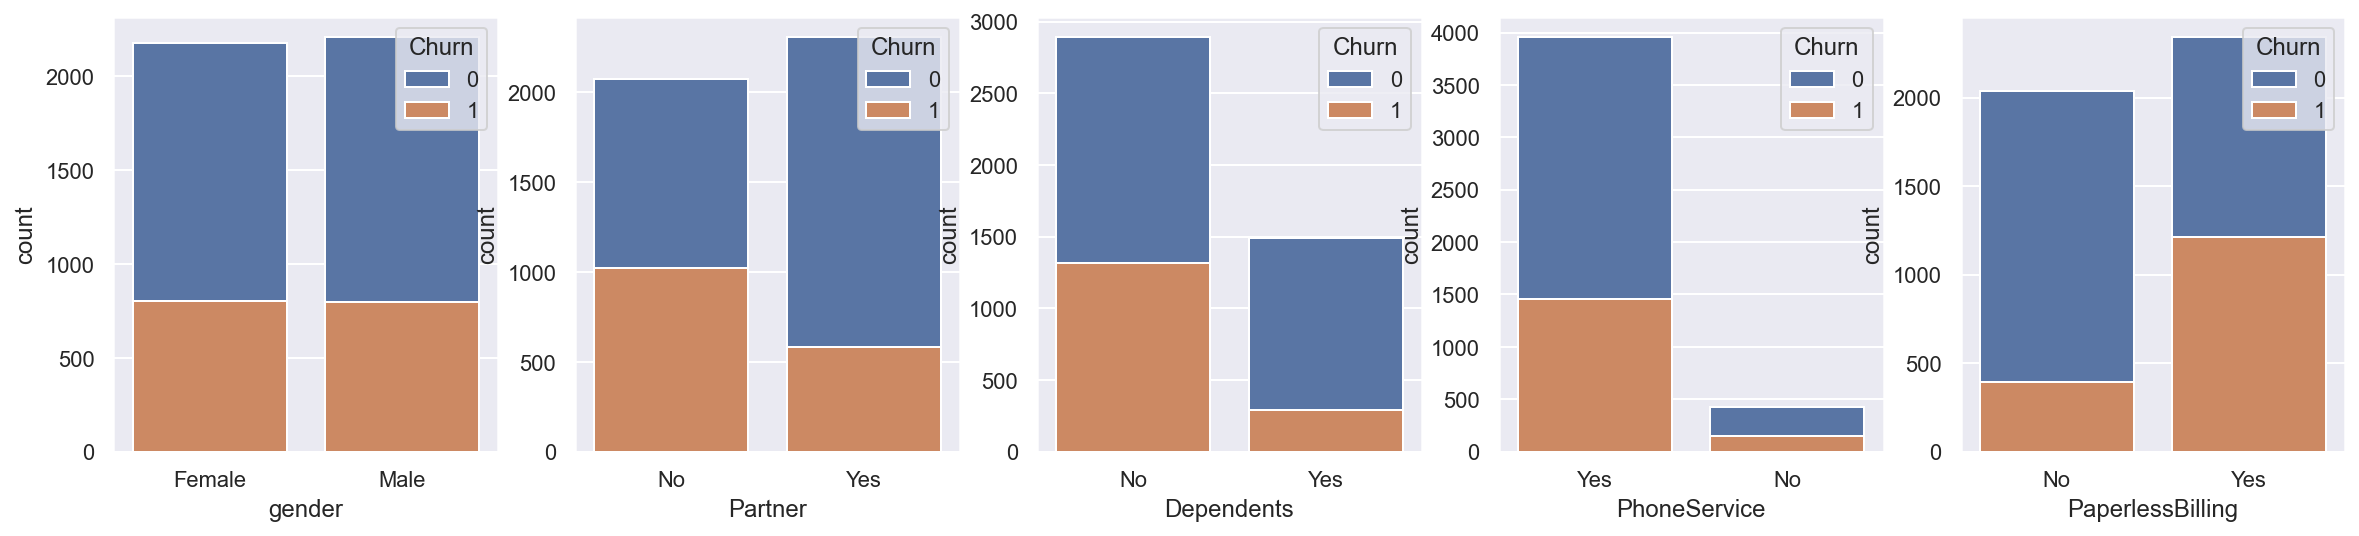

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for col, ax in enumerate(axs.flatten()):
    sns.countplot(data = df_churn, x = dis_df_col_bin[col], hue = 'Churn', dodge = False, ax = ax)

Independientemente de que lo relevantes que puedan ser a la hora de clasificar, parece que todas las variables y sus valores tienen sentido, por lo que se van a preservar. 

La siguiente función, `churn_binarize_dis`, recibe un _DataFrame_ y transforma las columnas de `dis_df_col_bin` a un entero binario.

In [13]:
# Para gender --> Male=0, Female=1
# Pare el resto: --> No=0, Yes=1
def churn_binarize_dis(df):
    df['gender'] = (df['gender']=='Female').apply(int)
    df['Partner'] = (df['Partner']=='Yes').apply(int)
    df['Dependents'] = (df['Dependents']=='Yes').apply(int)
    df['PhoneService'] = (df['PhoneService']=='Yes').apply(int)
    df['PaperlessBilling'] = (df['PaperlessBilling']=='Yes').apply(int)
    return df # No hace falta

# Comprueba si la función está bien
display(churn_binarize_dis(df_churn.head(5).copy()))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
6296-DDOOR,1,0,0,0,19,1,No,DSL,No,Yes,No,No,Yes,No,One year,0,Electronic check,58.20,1045.25,0
3680-CTHUH,0,0,0,0,60,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,1,Credit card (automatic),116.60,7049.5,0
4931-TRZWN,1,0,0,0,13,1,No,DSL,Yes,No,No,No,Yes,Yes,Month-to-month,1,Electronic check,71.95,923.85,0
8559-WNQZS,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,20.45,20.45,0
3537-HPKQT,1,0,1,0,55,1,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,1,Credit card (automatic),77.75,4266.4,0


Ha de añadirse la función  `churn_binarize_dis`  a la lista `churn_data_prep_pipeline`. Las variables transformadas, se han de tratar como numéricas, por lo que se añaden  a la lista `num_features`.

In [14]:
# Lo aplica
churn_binarize_dis(df_churn)

# Lo añade.
churn_data_prep_pipeline.append(churn_binarize_dis)

# Añade las variables
num_features.extend(dis_df_col_bin)
# Muestra las variables numéricas
print('Variables numéricas: ', num_features)

Variables numéricas:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


#### <font color="#7F000E"> Variables categóricas </font>

Las variables discretas que toman más de dos valores se pueden tratar como categóricas con _One Hot Encoding_ (posteriormente) o, si son ordinales, se pueden transformar a numéricas. En primer lugar, hay que explorar el tipo y distribución de valores de cada una de ellas, y ver si se pueden considerar como ordinales.  

A partir de `num_values_dis_df_col`, se pueden obtener los nombres de las columnas discretas que tienen más de dos valores y menos de cinco. Se almacenarán en una lista denominada `dis_df_columns_cat`.

In [15]:
dis_df_columns_cat = list(map(lambda cv: cv[0],(filter(lambda cv: cv[1]>2 and cv[1]<5, num_values_dis_df_col))))
dis_df_columns_cat

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 3</font>

Dibujar la distribución de cada una de estas variables utilizando una gráfica de tipo `sns.countplot()`. Para cada una de ellas para comprobar que todos los valores son correctos.

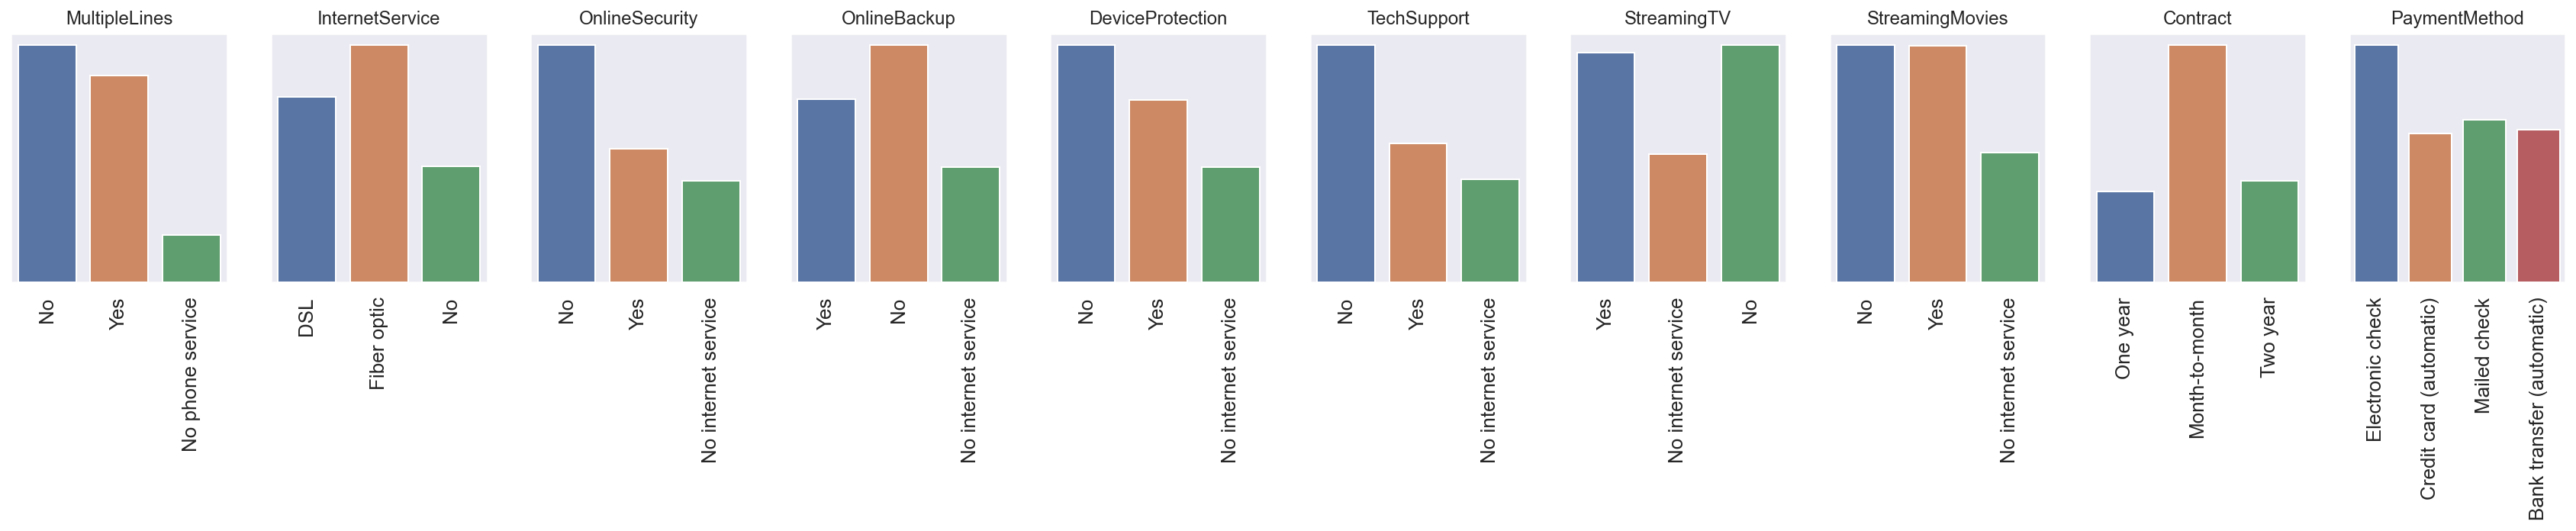

In [16]:
fig, axs = plt.subplots(1, 10, figsize=(30, 3))

for col, ax in enumerate(axs.flatten()):
    sns.countplot(data = df_churn, x = dis_df_columns_cat[col], ax = ax)

    # Para que se vean mejor
    ax.set_title(dis_df_columns_cat[col])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
    ax.set_yticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 4</font>

Explorar estas variables (de una en una) mediante `sns.countplot()`,  utilizando hue la relación de las variables con `Churn` (con `hue='Churn', dodge=False`). ¿Qué variable o variables parecen más relevantes? Dibujar solo una gráfica cada vez, y finalmente dejar solamente la  correspondiente a la variable más relevante (si la hubiera) y comentar por qué lo es.

<Figure size 720x360 with 0 Axes>

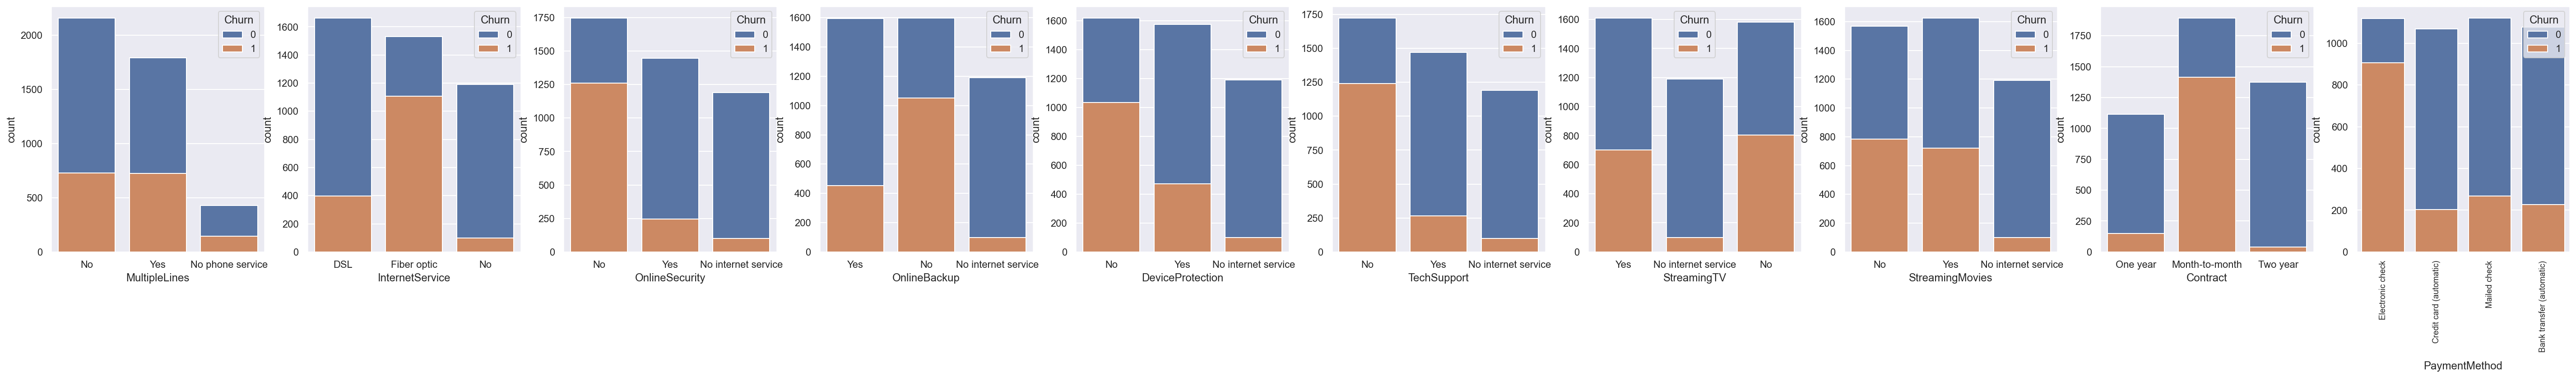

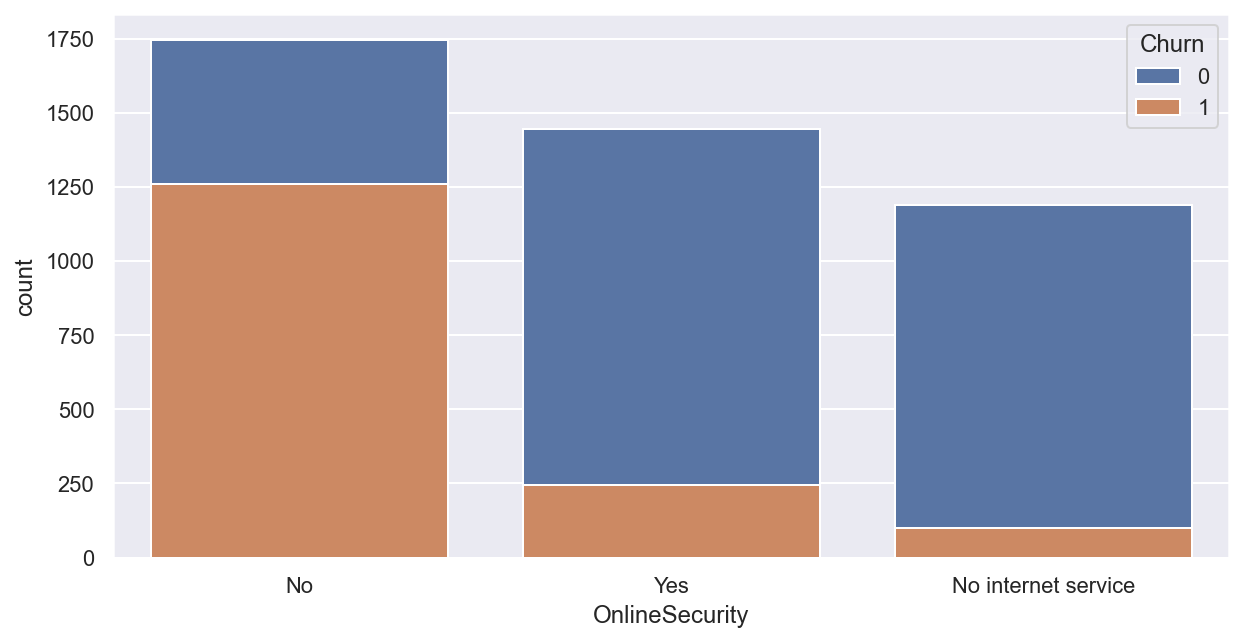

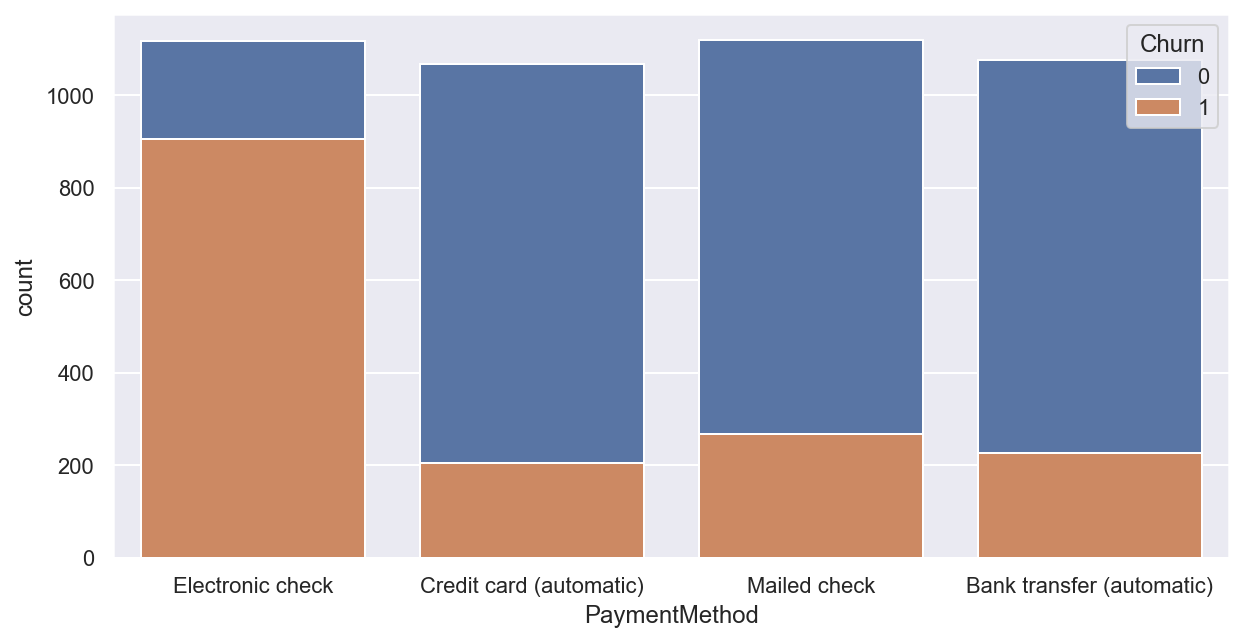

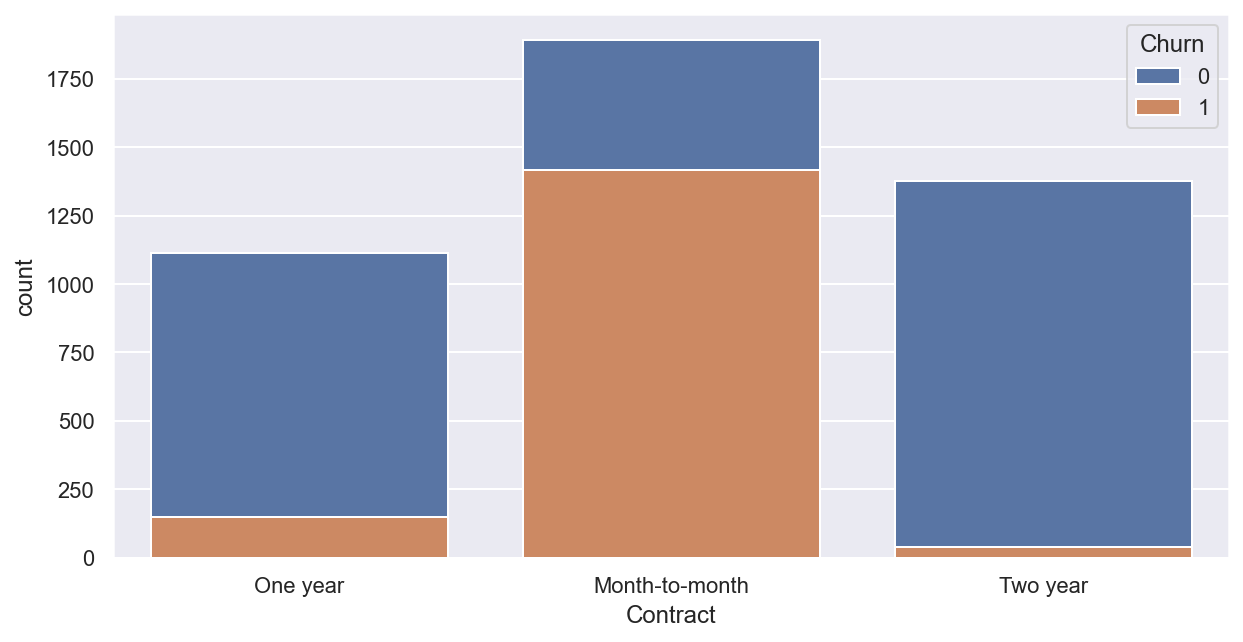

In [17]:

plt.figure(figsize=(10,5))
fig, axs = plt.subplots(1, 10, figsize=(50, 5))

for col, ax in enumerate(axs.flatten()):
    sns.countplot(data = df_churn, x = dis_df_columns_cat[col], hue = 'Churn', dodge = False, ax = ax)
    plt.xticks(rotation=90, fontsize=9)
    plt.xlabel(dis_df_columns_cat[col], labelpad=10)


plt.figure(figsize=(10,5))
sns.countplot(data = df_churn, x = dis_df_columns_cat[2], hue = 'Churn', dodge = False)
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data = df_churn, x = dis_df_columns_cat[9], hue = 'Churn', dodge = False)
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data = df_churn, x = dis_df_columns_cat[8], hue = 'Churn', dodge = False)
plt.show()

___Respuesta:___

De los diagramas de barras mostrados se puede inferir que las personas que tienen mayor tendencia a abandonar (Churn) son los que tienen contratos mensuales. Además, las personas que NO cuentan con Online Security (seguridad en línea) tienden a abandonar con mayor frecuencia que las que Sí cuentan con ese servicio. En contraste de las personas que ven streaming y las que no, en este caso no hay una diferencia muy marcada con el abandono (Churn).
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

En principio, parece que todas las columnas se podrían dejar como categóricas, aunque la columna `Contract` se _podría_ considerar ordinal. Por tanto, se añadirán todas las variables, menos `Contract`, a la lista `cat_features`.

In [18]:
cat_features = dis_df_columns_cat[:] # Copia la lista
cat_features.remove('Contract')      # Borra Contract
cat_features

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaymentMethod']

La función `churn_transform_contract` toma como entrada un *DataFrame* y convierte la columna `Contract` en numérica  asignando los valores a partir del diccionario `con_to_ordinal`.

In [19]:
con_to_ordinal = {'Month-to-month':1, 'One year':2, 'Two year':3}

def churn_transform_contract(df):
    df['Contract'] = df['Contract'].map(con_to_ordinal)
    
    return df # No hace falta

# Comprueba si la función está bien
display(churn_transform_contract(df_churn.head(5).copy()))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
6296-DDOOR,1,0,0,0,19,1,No,DSL,No,Yes,No,No,Yes,No,2,0,Electronic check,58.20,1045.25,0
3680-CTHUH,0,0,0,0,60,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,2,1,Credit card (automatic),116.60,7049.5,0
4931-TRZWN,1,0,0,0,13,1,No,DSL,Yes,No,No,No,Yes,Yes,1,1,Electronic check,71.95,923.85,0
8559-WNQZS,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,0,Mailed check,20.45,20.45,0
3537-HPKQT,1,0,1,0,55,1,Yes,Fiber optic,No,Yes,No,No,No,No,1,1,Credit card (automatic),77.75,4266.4,0


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 5</font>

Para esta variable, se ha hecho una asignación de valores ` {'Month-to-month':1, 'One year':2, 'Two year':3}`. Además de que es intuitiva,  parece consistente con la información que muestra la gráfica. ¿Por qué?

___Respuesta:___

El cambio de variables Categóricas a Ordinales son consistentes siempre que la variable categórica defina un orden. Por el contrario, si la variable categórica no describe un orden, por ejemplo Color: Azul, Verde, Rojo, realizar un cambio a ordinal supondría perdida de información. 
Para el caso dado, tiene sentido debido a que Mes a Mes es de un orden menor a 1 Año y este es menor a 2 años. Por ello, la variable contrato define un orden inherente que es compatible con el cambio a Ordinal
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>



En este punto, se debe añadir la función `churn_transform_contract` a `churn_data_prep_pipeline`, aplicarla al `DataFrame` `df_churn`, e incluir `Contract` en la lista de columnas numéricas, `num_features`. 

In [20]:
# Lo aplica
churn_transform_contract(df_churn)

# Lo añade.
churn_data_prep_pipeline.append(churn_transform_contract)

# Añade las variables
num_features.append('Contract')

# Las muestra
print('Variables numéricas: ', num_features)

Variables numéricas:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Contract']


#### <font color="#7F000E"> Total Charges </font>

La columna `TotalCharges`, a pesar de estar representada como un objeto, contiene datos numéricos. Debido a esto, se va a transformar en numérica, asignando valores `NaN` a las entradas que no se han podido transformar en numéricas al leer el *DataFrame*. La función `churn_charges_to_numeric` toma como entrada un *DataFrame* y convierte la columna `TotalCharges` en numérica.

In [21]:
def churn_charges_to_numeric(df):
    df['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors='coerce')
    return df # No hace falta

# Comprueba si la función está bien
display(churn_charges_to_numeric(df_churn.head(5).copy()))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
6296-DDOOR,1,0,0,0,19,1,No,DSL,No,Yes,No,No,Yes,No,2,0,Electronic check,58.20,1045.25,0
3680-CTHUH,0,0,0,0,60,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,2,1,Credit card (automatic),116.60,7049.50,0
4931-TRZWN,1,0,0,0,13,1,No,DSL,Yes,No,No,No,Yes,Yes,1,1,Electronic check,71.95,923.85,0
8559-WNQZS,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,0,Mailed check,20.45,20.45,0
3537-HPKQT,1,0,1,0,55,1,Yes,Fiber optic,No,Yes,No,No,No,No,1,1,Credit card (automatic),77.75,4266.40,0


La función `churn_charges_to_numeric` también se añade `churn_data_prep_pipeline` y se aplica `df_churn`. Se ha de incluir `TotalCharges` en la lista de columnas numéricas, `num_features`. 

In [22]:
# Lo aplica
churn_charges_to_numeric(df_churn)

# Lo añade.
churn_data_prep_pipeline.append(churn_charges_to_numeric)

# Añade las variables
num_features.append('TotalCharges')

# Las muestra
print('Variables numéricas: ', num_features)

Variables numéricas:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Contract', 'TotalCharges']


Hasta el momento, estos son los pasos que se han llevado a cabo en el preprocesamiento.

In [23]:
print("\nPasos de preprocesamiento: ")
for step, function in enumerate(churn_data_prep_pipeline):
    print("\t {:d}: {:s}".format(step, function.__name__))


Pasos de preprocesamiento: 
	 0: churn_binarize_dis
	 1: churn_transform_contract
	 2: churn_charges_to_numeric


Y estas son las características (*originalmente discretas*) que serán tratadas como categóricas y como numéricas.

In [24]:
print('Variables categóricas: ',cat_features, end='\n\n')
print('Variables numéricas: ',num_features)

Variables categóricas:  ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']

Variables numéricas:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Contract', 'TotalCharges']


### <font color="#7F000E">Tratamiento de las columnas numéricas </font>
<br>

El tratamiento de las columnas numéricas es relativamente sencillo, y se puede descomponer en varias etapas:

* Comprobar que, efectivamente, corresponden a características numéricas. 
* Detección y tratamiento de outliers. 
* Detección y tratemiento de valores perdidos. 
* Exploración de las variables. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
Esta es una posible descomposición, y ha de considerarse como sugerencia. Si los *outliers* se sustituyen por valores perdidos, deben tratarse antes que estos.
</div>

#### <font color="#7F000E"> Comprobación de tipos </font>

En algunos casos, las columnas numéricas pueden representar características categóricas. Para detectar esta situación es posible apoyarse, además de en el nombre (descriptivo) de las columnas, en el número de valores que éstas toman. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Otra opción consiste en elaborar gráficas (pero se harán después porque en este caso no es necesario).
</div>

A continuación, se obtiene el número de valores para cada una de las variables que han sido almacenadas como numéricas en el *DataFrame* original (`num_df_columns`). 

In [25]:
list(map(lambda col: "{:s}: {:d}".format(col,len(df_churn[col].value_counts())), num_df_columns))

['SeniorCitizen: 2', 'tenure: 73', 'MonthlyCharges: 1529', 'Churn: 2']

Parece dos de las variables son binarias, y otras dos son numéricas, por lo que no hay que hacer cambios. 

#### <font color="#7F000E"> Outliers </font>


Existen varios métodos para llevar a cabo la detección de outliers. Por ejemplo, en el caso de que el número de características sea reducido, y que las escalas sean similares, se podría utilizar un gráfico de cajas. Otra posibilidad consite en visualizar los rangos que toman las variables.  

In [26]:
df_churn[num_df_columns.to_list()+['TotalCharges']].describe(percentiles=[0.01,0.25,0.5,0.75,0.99])

,SeniorCitizen,tenure,MonthlyCharges,Churn,TotalCharges
count,5986.000000,5986.000000,5986.000000,5986.000000,5977.000000
mean,0.166889,32.186435,64.821024,0.267959,2273.195483
std,0.372908,24.503081,30.033744,0.442933,2258.880108
min,0.000000,0.000000,18.250000,0.000000,18.800000
1%,0.000000,1.000000,19.150000,0.000000,19.850000
25%,0.000000,9.000000,35.825000,0.000000,400.000000
50%,0.000000,28.000000,70.400000,0.000000,1396.250000
75%,0.000000,55.000000,89.850000,1.000000,3772.650000
99%,1.000000,72.000000,114.557500,1.000000,8027.362000
max,1.000000,72.000000,118.750000,1.000000,8684.800000


Parece que los valores mínimo y máximo en las variables `tenure`, `MonthyCharges` y `TotalCharges` no se alejan excesivamente de los rangos razonables en ningún caso. Por tanto, no hay que proceder en este caso. 

#### <font color="#7F000E"> Valores perdidos </font>


A continuación, se comprueba si existen valores perdidos para alguna de las variables numéricas. 

In [27]:
df_churn[num_df_columns.to_list()+['TotalCharges']].isna().any()

SeniorCitizen     False
tenure            False
MonthlyCharges    False
Churn             False
TotalCharges       True
dtype: bool

Puede apreciarse que solo los hay para `TotalCharges`. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
El tratamiento de los valores perdidos es conveniente hacerlo en el _pipeline_ de `scikit-learn`, ya que en muchos casos se usará la media o mediana de la variable en el conjunto de entrenamiento, y este valor se ha de almacenar.
</div> 

#### <font color="#7F000E"> Exploración </font>


Por último, puede resultar de interés llevar a cabo una pequeña exploración de las variables numéricas para ver tanto sus distribuciones como su relación con la clase. Es importante recordar que anteriormente se convirtieron algunas variables discretas a numéricas. Por tanto, se actualizará la lista `num_features`, añadiendole los elementos de `num_df_colums`.

In [28]:
num_features = num_features + num_df_columns.to_list()  
num_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Contract',
 'TotalCharges',
 'SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'Churn']


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 6</font>

Dibujar, para las variables `tenure`, `MonthlyCharge` y `TotalCharges` (las que no son binarias), un gráfico del tipo `sns.kdeplot()` que muestre la distribución de valores para cada una de las clases (dos distribuciones por gráfica). Utilizar una figura de $1 \times 3$ gráficas. Comentar qué se observa en la gráfica. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> 
Si da error, utilizar como fuente de datos `df_churn.dropna()`.
</div> 

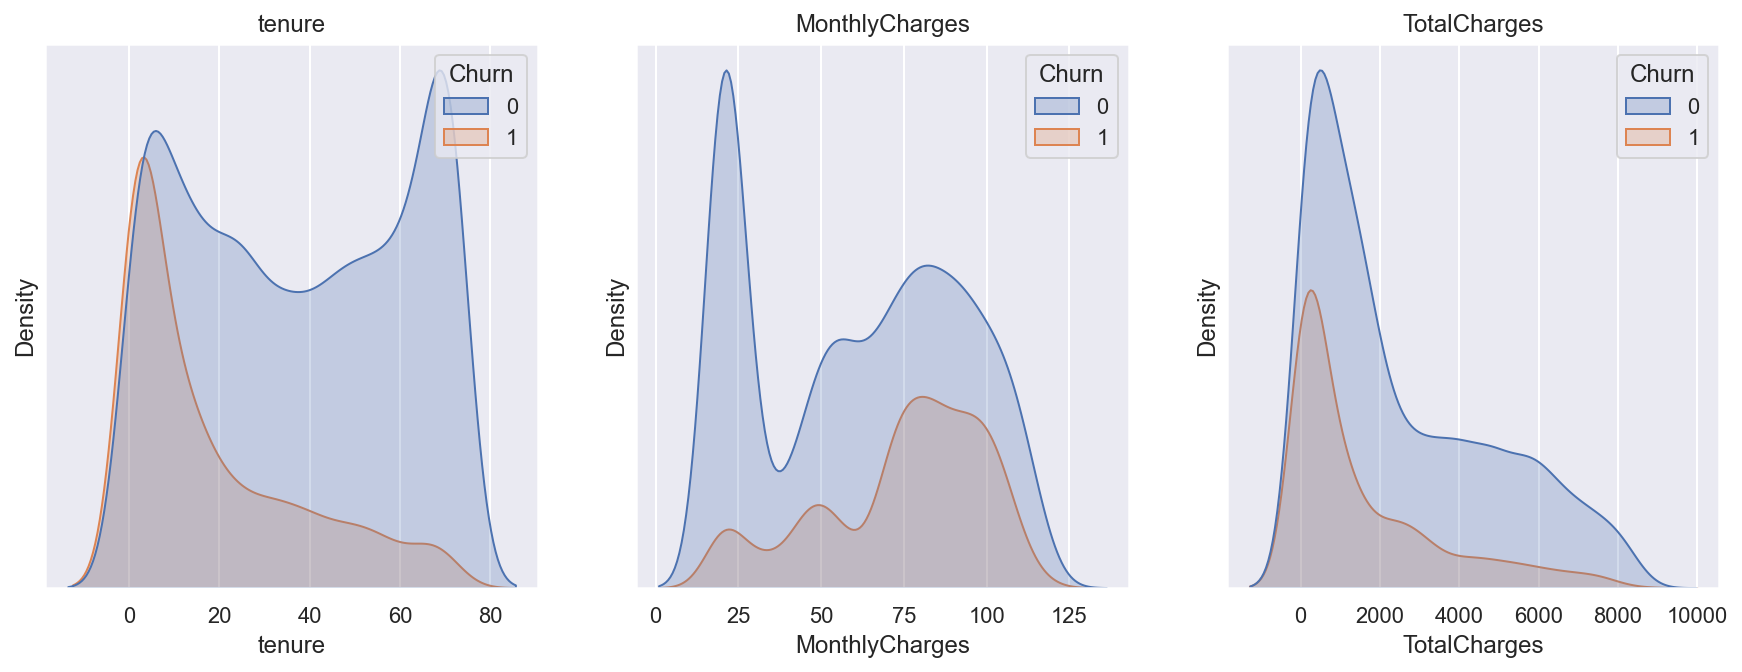

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
features = ['tenure', 'MonthlyCharges','TotalCharges']
for col, ax in enumerate(axs.flatten()):
    col_name = features[col]
    sns.kdeplot(data = df_churn, x = features[col], hue = 'Churn', shade = True, ax = ax)
    ax.set_title(features[col]);    
    ax.set_yticks([])

___Respuesta:___

De la gráfica es desarrollada, es útil observar la forma de la distribución, para el caso Total Charges tanto la de Churn Si como No tienen una forma similar, por lo que no se podría ser concluyente. Sin embargo, para tenure, se puede observar que para mayores valores la tasa de permanencia (Churn No) aumenta. Asímismo para Monthly Charges, mientras el monto a pagar mensualmente es menor la tasa de permanencia (Churn no) aumenta.

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 7</font>
Calcular la correlacción entre las variables y mostrarla en una gráfica `sns.heatmap()` y comentar qué se observa en la gráfica. 

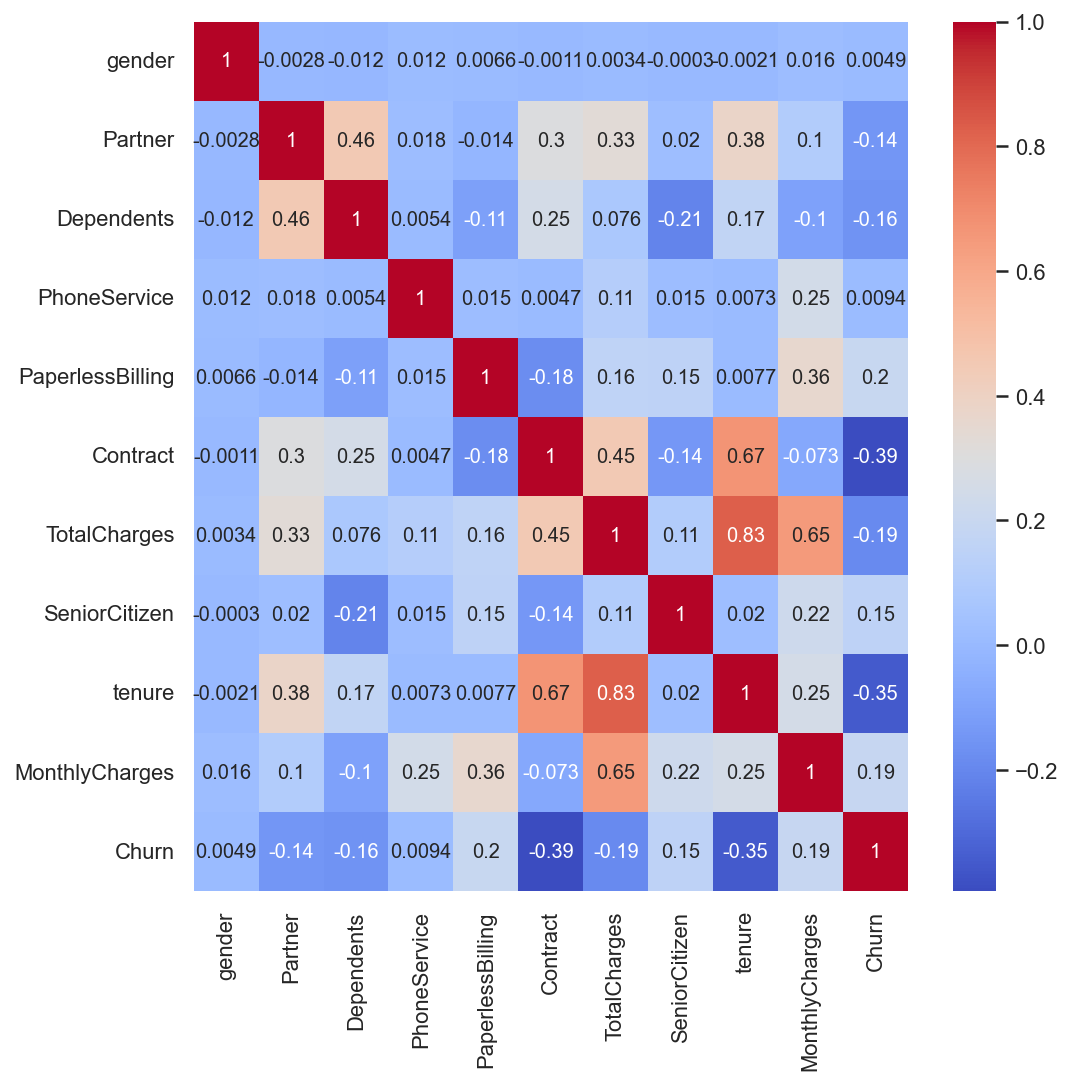

In [30]:
corrmat = df_churn[num_features].corr(method='pearson')

# Mapa de calor con seaborn
plt.figure(figsize=(8,8))


sns.heatmap(corrmat, annot=True, cmap='coolwarm')

plt.show()

___Respuesta:___

De la correlación y del mapa de calor se puede observar que hay una correlación fuerte entre Tenure y Total Charges.
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

<br>

### <font color="#7F000E">Preprocesamiento</font>
<br>

Llegados a este punto, se han llevado a cabo las acciones de preprocesamiento necesarias. En el _DataFrame_ resultante quedan características numéricas, y también categóricas, que serán tratadas como tal en pasos posteriores. Con respecto a las numéricas, ha de eliminarse `Churn`.

In [31]:
num_features.remove('Churn')

print("Variables numéricas: ")
print(num_features)
print("\nVariables categóricas")
print(cat_features)

df_churn.head()

Variables numéricas: 
['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Contract', 'TotalCharges', 'SeniorCitizen', 'tenure', 'MonthlyCharges']

Variables categóricas
['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
6296-DDOOR,1,0,0,0,19,1,No,DSL,No,Yes,No,No,Yes,No,2,0,Electronic check,58.20,1045.25,0
3680-CTHUH,0,0,0,0,60,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,2,1,Credit card (automatic),116.60,7049.50,0
4931-TRZWN,1,0,0,0,13,1,No,DSL,Yes,No,No,No,Yes,Yes,1,1,Electronic check,71.95,923.85,0
8559-WNQZS,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,0,Mailed check,20.45,20.45,0
3537-HPKQT,1,0,1,0,55,1,Yes,Fiber optic,No,Yes,No,No,No,No,1,1,Credit card (automatic),77.75,4266.40,0


En relación al preprocesamiento, se han aplicado, sucesivamente, las siguientes funciones (deben aparecer las tres).

In [32]:
print("\nPasos de preprocesamiento: ")
for step, function in enumerate(churn_data_prep_pipeline):
    print("\t {:d}: {:s}".format(step, function.__name__))


Pasos de preprocesamiento: 
	 0: churn_binarize_dis
	 1: churn_transform_contract
	 2: churn_charges_to_numeric


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 8</font>

Implementar una función, denominada `preprocess_data`, que admite como parámetros un _DataFrame_ y una lista de funciones como la anterior, y las aplica sucesivamente sobre el _DataFrame_.

In [33]:
def preprocess_data(df, churn_data_prep_pipeline):
    churn_binarize_dis(df)
    churn_transform_contract(df)
    churn_charges_to_numeric(df)    
    
    return df

La siguiente celda aplica la función `preprocess_data` sobre un _DataFrame_ auxiliar. Como puede observarse, el formato devuelto es similar al de `df_churn` una vez hecho el preprocesamiento.

In [34]:
df_aux = pd.read_csv('data/churn/Telco-Customer-Churn.csv', index_col=0).sample(n=5, random_state=0)
preprocess_data(df_aux, churn_data_prep_pipeline)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
6296-DDOOR,1,0,0,0,19,1,No,DSL,No,Yes,No,No,Yes,No,2,0,Electronic check,58.20,1045.25,No
3680-CTHUH,0,0,0,0,60,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,2,1,Credit card (automatic),116.60,7049.50,No
4931-TRZWN,1,0,0,0,13,1,No,DSL,Yes,No,No,No,Yes,Yes,1,1,Electronic check,71.95,923.85,No
8559-WNQZS,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,0,Mailed check,20.45,20.45,No
3537-HPKQT,1,0,1,0,55,1,Yes,Fiber optic,No,Yes,No,No,No,No,1,1,Credit card (automatic),77.75,4266.40,No


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section12"></a>
## <font color="#7F000E"> 1.2. Construcción de un modelo </font>
<br>

En este punto, se ha definido un flujo de acciones de preprocesamiento, y se ha preparado un _DataFrame_ a partir del cual se puede construir y validar el modelo. Este conjunto de datos será el punto de partida para la definición de un _Pipeline_ con `scikit-learn`, que también incluye ciertas acciones de transformación, y es "independiente" del proceso anterior.  No obstante, sí que será necesario utilizar las listas de características elaboradas anteriormente. Por otra parte, se almacenarán las columnas de entrada en `X` y la clase en `y`.

In [35]:
X = df_churn.drop('Churn',1)
y = df_churn['Churn']

### <font color="#7F000E"> Creación de un Pipeline para la transformación</font>


El primer paso en la creación del _Pipeline_ consiste en la transformación de los datos. Uno de los problemas con los que tradicionalmente se ha lidiado en este sentido, es que se han de tratar de manera separada los datos de distintas columnas, que luego han de ser unidas. Esto conlleva la implementación de transformadores. Desde la versión 0.20 `scikit-learn` proporciona el objeto  [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer), que permite tratar por separado las columnas, y facilita enormemente la tarea de transformación.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Podéis leer un par de artículos sobre `ColumnTransformer` en estos enlaces: [post 1](https://medium.com/vickdata/easier-machine-learning-with-the-new-column-transformer-from-scikit-learn-c2268ea9564c) (básico) y [post 2](https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62) (más complejo pero muy interesante).
</div>

<br>

En este contexto, el preprocesamiento para todas las variables de un mismo tipo será similar, por lo que serán sometidas a la misma secuencia de transformaciones mediante un _Pipeline_. Una vez definido el _Pipeline_ para cada tipo de datos, se aplicarán ambos a las columnas correspondientes mediante `ColumnTransformer`.

En primer lugar, se va a definir el proceso de transformación para las variables numéricas, que consistirá en:
* Imputación de valores perdidos (`SimpleImputer`). 
* Normalización a media cero y desviación uno (`StandardScaler`).

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 9</font>

Crear un `Pipeline`, denominado `num_transformer`, que consista en las dos transformaciones descritas anteriormente. 

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> __Importante__. La normalización de las características mediante `StandardScaler` es, por ejemplo, una de las transformaciones que hay que hacer dentro del *pipeline*, ya que utiliza las medias y desviaciones estándar de las características en el conjunto de entrenamiento, y las almacena para reescalar en nuevos datos. 
</div>


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 10</font>

Crear otro _Pipeline_, denominado `cat_transformer`, que defina la secuencia de transformaciones para las variables categóricas. Este debe estar formado por un objeto `SimpleImputer` que reemplace los valores perdidos por la etiqueta `missing` (`strategy='constant', fill_value='missing'`), y otro objeto, `OneHotEncoder` que transforme las variables categóricas a etiquetas binarias. Para este último, fijar el parámetro `handle_unknown='ignore'` para que los valores que no se han consierado en el entrenamiento, sean ignorados (codificados a cero).

In [37]:
from sklearn.preprocessing import OneHotEncoder

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 11</font>

Crear un objeto de tipo `ColumnTransformer`, denominado `churn_trans`, que aplique las dos secuencias anteriores de transformación sobre las características correspondientes. 

In [38]:
from sklearn.compose import ColumnTransformer

churn_trans = ColumnTransformer(transformers=[('num', num_transformer,num_features), ('cat', cat_transformer,cat_features)])



### <font color="#7F000E"> Creación de un Pipeline con un modelo de regresión logística</font>
<br>

Una vez defenidas las operaciones de transformación, se creará un _pipeline_ que será utilizado para aprender un modelo de regresión logística.

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 12</font>

Crear un objeto `Pipeline` que encadene la transformación definida en el objeto `churn_trans` anterior, y un modelo de regresión logística. Este modelo (_Pipeline_) se denominará `churn_pipe_logr`, y los pasos de transformación y clasificación, `prep` y `clas` respectivamente.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logr_model = LogisticRegression();

churn_pipe_logr = Pipeline(steps=[('prep', churn_trans ),('clas', logr_model)])


De cara a aprender el modelo predictivo (_Pipeline_ `churn_pipe_logr`), se han de ajustar varios parámetros. En concreto: 
* El valor utilizado para imputar valores perdidos numéricos `strategy`, que podrá ser `mean` o `median`.
* La constante de regularización para regresión logística, `C`, que puede ser `[10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]`.
* El parámetro `class_weight` en regresión logística, que puede ser `[None, 'balanced']`, y determina si el peso de cada ejemplo en la función del coste es el mismo o no.

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 13</font>

Entrenar un objeto `GridSearchCV` para determinar cual es el mejor flujo de trabajo; almacenar el resultado en la variable `GS`. Utilizar validación cruzada de 5 folds, y la función `scoring` adecuada. Almacenar el mejor modelo encontrado en la variable `churn_pipe_logr` (la definida anteriormente).

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> El parámetro `refit=True` (valor por defecto) hace que, una vez determinada la mejor configuración de parámetros, se entrene el modelo con todos los datos.
</div>

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

parameters = {}
parameters['prep__num__imputer__strategy'] = ['mean', 'median']
parameters['clas__C'] = [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
parameters['clas__class_weight'] = [None, 'balanced']

kf = KFold(n_splits=5, shuffle=True)
GS = GridSearchCV(churn_pipe_logr, parameters, cv=kf, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, shuffle = True, random_state = 0)
GS.fit(X_train, y_train)
    
print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

churn_pipe_logr = GS.best_estimator_

Mejor score:  0.8009546539379475
Mejore configuración de parámetros:  {'clas__C': 100, 'clas__class_weight': None, 'prep__num__imputer__strategy': 'median'}


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 14</font>

Contestar a las siguientes preguntas. 

___1)___ ¿Para qué sirve el parámetro C (Equivale a $1/\lambda$, siendo $\lambda$ el parámetro visto en clase)?
<br>

___Respuesta:___

El parámetrto C determina la el ajuste (o sobreajuste) de los modelos de regresión logística. La idea es evitar el sobreajustamiento en los modelos de machine learning. Por un lado,si el parámetro C es alto esto indica que el modelo debe ajustarse a los datos (de entrenamiento) tanto como sea posible. Por otro lado, si el parámetro C es bajo esto indica que el modelo debe de generalizar mejor a los nuevos datos. Por ello, el parámetro C va a depender del tipo de caso de cada conjunto de datos y del modelo que se esté usando.
<br>

___2)___ ¿Por qué se utilizan todos los datos `refit=True` para entrenar el mejor modelo una vez encontrados los parámetros?
<br>

___Respuesta:___

Esto se utiliza para entrenar el mejor modelo una vez encontrados los los mejores parámetros utilizando todos los datos de entrenamiento disponibles, sin limitarse a los datos empleados en la validación cruzada. Por ello el modelo reaprendido final se ajusta a todos los datos de entrenamiento disponible, maximizando la precisión del modelo. 
<br>

___3)___ ¿Qué función has utilizado como `scoring`? ¿Por qué?
<br>

___Respuesta:___

La metrica 'accuracy' se suele usar para problemas de clasificación binaria, tal como ocurre en este caso (Churn Si / No).
<br>

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

### <font color="#7F000E"> Evaluación del modelo </font>

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 15</font>

Implementar una función, denominada `show_results`, que reciba dos vectores de igual tamaño, denominados `y` e `y_pred`, con las salidas reales y predicciones del modelo respectivamente; dibuje la matriz de confusión; e imprima por pantalla las métricas de interés. Utilizar `show_results` para mostrar los resultados del modelo anterior y comentar los resultados

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def show_results(y, y_pred):
    from sklearn.metrics import confusion_matrix
    c_mat = confusion_matrix(y, y_pred)
    sns.heatmap(c_mat, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados: ")
    print(f'\taccuracy: {accuracy_score(y, y_pred):.3f}')
    print(f'\trecall: {recall_score(y, y_pred):.3f}')
    print(f'\tprecision: {precision_score(y, y_pred):.3f}')
    print(f'\tf1_score: {f1_score(y, y_pred):.3f}')

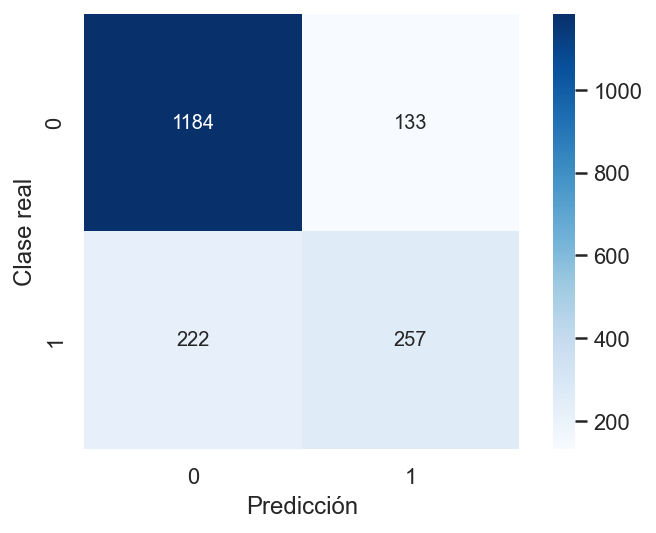

Resultados: 
	accuracy: 0.802
	recall: 0.537
	precision: 0.659
	f1_score: 0.591


In [42]:
y_pred = churn_pipe_logr.predict(X_test)

show_results(y_test, y_pred)

___Respuesta:___

En general el modelo ha detectado el 80,3% de las predicciones dadas. Además, tiene una proporción de verdaderos positivos con respecto al total entre verdaderos positivos y falsos negativos de 53.7%, esto indica que tan bien el modelo puede predecir los positivos, o abandonos. Su precisión de para identificar correctamente los casos positivos es del 66.1% y finalmente, la capacidad del modelo para identificar correctamente las muestras positivas (minimizando los falsos positivos y falsos negativos) es del 58.2%. Estas métricas pueden mejorar si se realiza un tratamiento a los datos para balancear las muestras (Churn= Si y Churn= No). 
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

#### <font color="#7F000E"> Calibración del modelo</font>


En el modelo de regresión logística, por ejemplo $c_\theta(x)=1$ si $h_\theta(x)>0.5$. Es posible cambiar este umbral (0.5), y con ello se modifican las propiedades del clasificador. Esto es aplicable a todos los modelos que devuelven probabilidad. En este apartado, veremos como afecta este cambio utilizando 3 umbrales: 0.25, 0.5, y 0.75.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> Por simplicidad, no incluiremos este proceso en el _Pipeline_.
</div>

In [43]:
y_prob = churn_pipe_logr.predict_proba(X)[:,1]

* $c_\theta(x)=1$ si $h_\theta(x) >= 0.25$

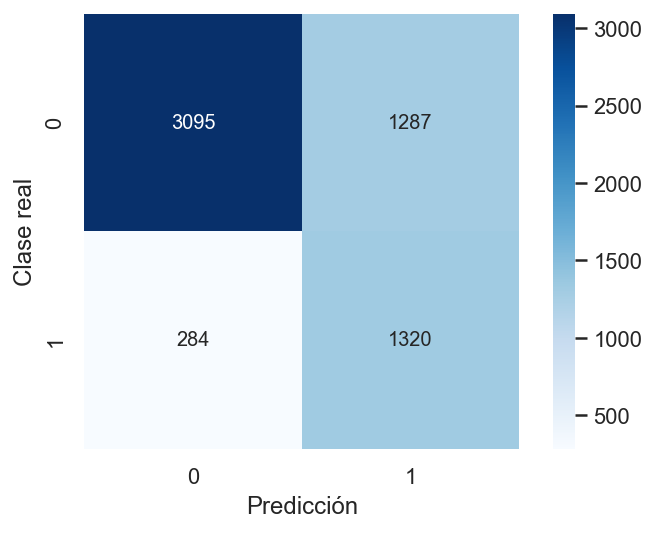

Resultados: 
	accuracy: 0.738
	recall: 0.823
	precision: 0.506
	f1_score: 0.627


In [44]:
y_pred = y_prob >= 0.25
show_results(y, y_pred)

* $c_\theta(x)=1$ si $h_\theta(x) >= 0.5$

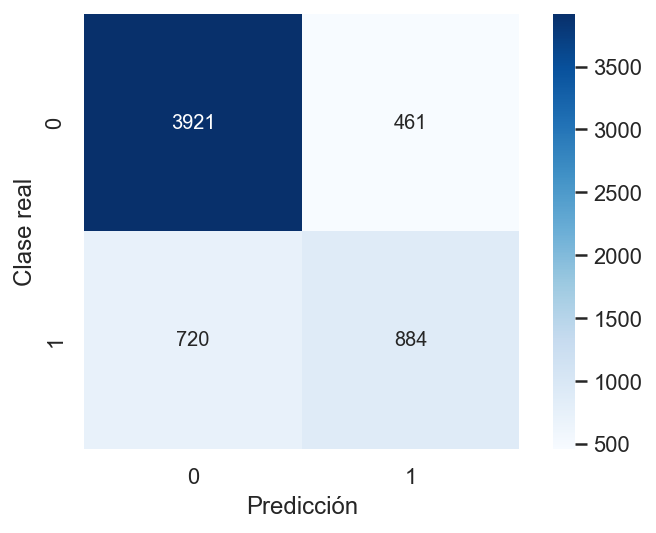

Resultados: 
	accuracy: 0.803
	recall: 0.551
	precision: 0.657
	f1_score: 0.600


In [45]:
y_pred = y_prob >= 0.5
show_results(y, y_pred)

* $c_\theta(x)=1$ si $h_\theta(x) >= 0.75$

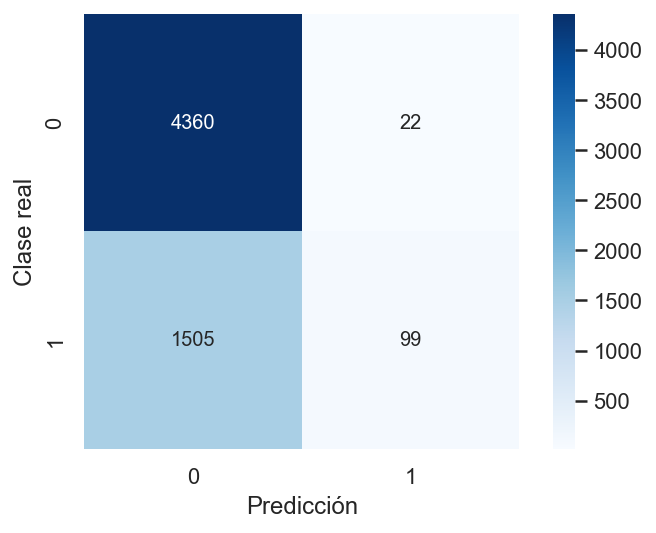

Resultados: 
	accuracy: 0.745
	recall: 0.062
	precision: 0.818
	f1_score: 0.115


In [46]:
y_pred = y_prob >= 0.75
show_results(y, y_pred)

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 16</font>

¿Cómo influye el cambio del umbral en las distintas métricas? ¿Por qué?

___Respuesta:___

Al aumentar el umbral de activación (Threshold) se aumenta la precisión y se reduce la recuperación (recall). Esto puede deberse a que al ser el umbral más grande se clasifican menos casos como Positivos, reduciendo con ello los valores de Falsos Positivos y aumentando la precisión. Además, tambien se clasifican menos Verdaderos Positivos aumentando de este modo los Falsos Negativos, lo que impacta la métrica de Recall, disminuyéndola. Si el umbral disminuye la consecuencia, debido a lo expuesto anteriormente, es de reducción en la precisión y aumento de la recuperación (recall). Finalmente, es importante notar que todo cambio en el umbral de activación repercute directamente en la relación Precision | Recall.
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 17</font>

Dibujar la curva _precision/recall_ utilizando `sklearn.metrics.precision_recall_curve`. ¿Qué umbral es el más adecuado para este caso? ¿De qué factor dependería?

Umbrales considerados: 		 [0.227 0.5   0.805]
Predicciones (valores únicos):   [0.0012 0.0012 0.0012 ... 0.8266 0.8308 0.8337]


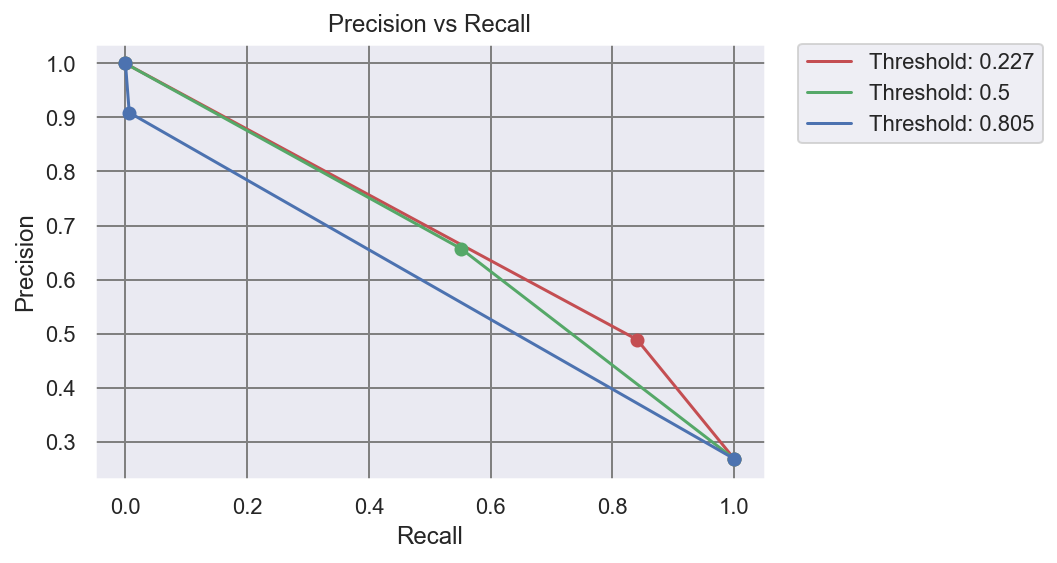

In [47]:
from sklearn.metrics import precision_recall_curve

y_pred = y_prob >= 0.227
precision, recall, threshold = precision_recall_curve(y, y_pred)
plt.plot(recall, precision, 'r', label = 'Threshold: 0.227') 
plt.plot(recall, precision, 'or')

y_pred = y_prob >= 0.5
precision, recall, threshold = precision_recall_curve(y, y_pred)
plt.plot(recall, precision, 'g', label = 'Threshold: 0.5') 
plt.plot(recall, precision, 'og')

y_pred = y_prob >= 0.805
precision, recall, threshold = precision_recall_curve(y, y_pred)
plt.plot(recall, precision, 'b', label = 'Threshold: 0.805') 
plt.plot(recall, precision, 'ob')

plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision');

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

print("Umbrales considerados: \t\t", np.round([0.227, 0.5, 0.805],4))
print("Predicciones (valores únicos):  ", np.round(np.unique(y_prob),4))

___Respuesta:___

En el gráfico de precisión vs ehaustividad es de utilidad para evaluar el rendimiento de un modelo dado, de forma ideal se espera que tanto la precisión como la exhaustividad sean lo más alto posible. Por ello, se puede apreciar que la linea verde tiene la mayor precisión y exhaustividad de los 3 umbrales, en este caso Threshold = 0.5. 

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---


<a id="section13"></a>
## <font color="#7F000E"> 1.3 Validación sobre nuevos datos </font>
<br>



En este proceso se ha construído el modelo, y se dispone del flujo de trabajo completo, que se compone por una preparación de la base de datos original mediante `preprocess_data`, y del _Pipeline_ `churn_pipe_logr`. 

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 18</font>

Utilizar ambos para predecir los casos de abandono en `df_churn_new`. Puede utilizarse también un umbral de entre los seleccionados anteriormente. Mostrar los resultados.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Ha de convertirse la clase a `int` porque ese paso se había sacado fuera del pipeline.                   
</div>

In [48]:
df_churn_new['Churn'] = (df_churn_new['Churn']=='Yes').astype(int)

preprocess_data(df_churn_new, churn_data_prep_pipeline)

X_new = df_churn_new.drop('Churn',1)
y_new = df_churn_new['Churn']

y_pred_new = GS.best_estimator_.predict(X_new)

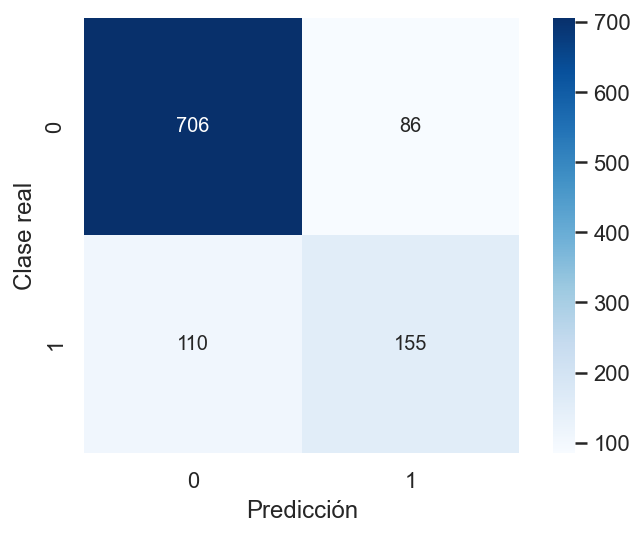

Resultados: 
	accuracy: 0.815
	recall: 0.585
	precision: 0.643
	f1_score: 0.613


In [49]:
y_prob_new = churn_pipe_logr.predict_proba(X_new)[:,1]
y_pred_new = y_prob_new >= 0.5
show_results(y_new, y_pred_new)

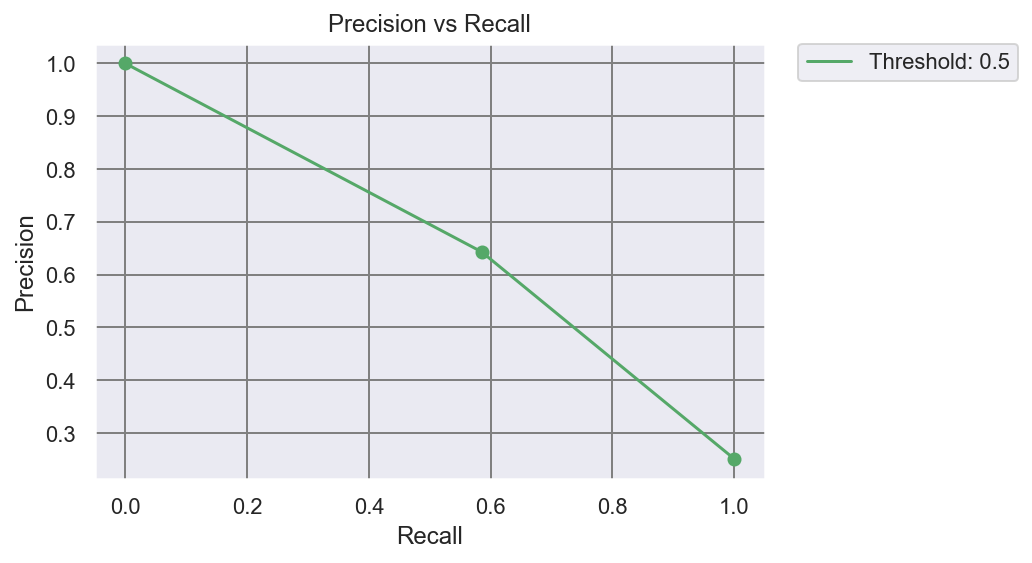

In [50]:
precision, recall, threshold = precision_recall_curve(y_new, y_pred_new)
plt.plot(recall, precision, 'g', label = 'Threshold: 0.5') 
plt.plot(recall, precision, 'og')
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---


<a id="section14"></a>
## <font color="#7F000E"> 1.4 Comparación con otros clasificadores </font>
<br>

Una vez definido el proceso, se repetirá el entrenamiento con otros clasificadores: Un árbol y una máquina de soporte vectorial.

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 19</font>

 Construir un _Pipeline_ similar al anterior, denominado `churn_pipe_tree`, pero utilizando un árbol.  Determinar la mejor configuración de los parámetros con `GridSearchCV`, utilizando como `scoring` la medida que consideréis más adecuada. Guardar el modelo resultante en `churn_pipe_tree`. Mostrar los resultados con respecto al conjunto de nuevos datos `X_new, y_new`. 

Mejor score:  0.8011307225592941
Mejore configuración de parámetros:  {'clas__class_weight': None, 'clas__max_depth': 3, 'prep__num__imputer__strategy': 'mean'}


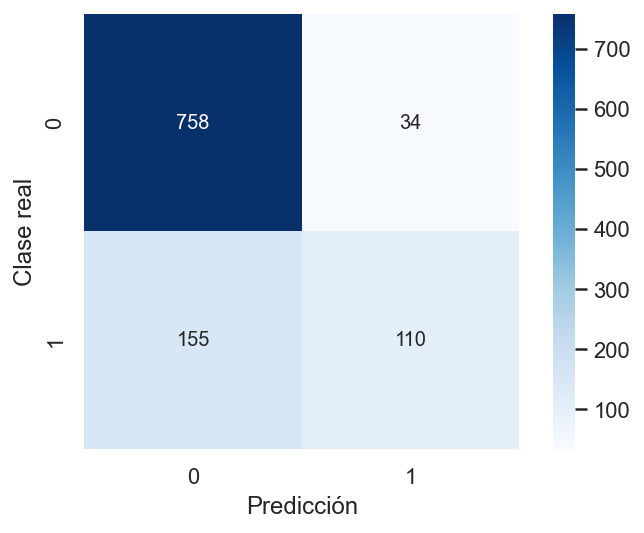

Resultados: 
	accuracy: 0.821
	recall: 0.415
	precision: 0.764
	f1_score: 0.538


In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_model = DecisionTreeClassifier();

churn_pipe_tree = Pipeline(steps = [('prep', churn_trans),('clas', dt_model)])

parameters = {}
parameters['prep__num__imputer__strategy'] = ['mean', 'median']
parameters['clas__max_depth'] = [None, 3, 5, 7, 9]
parameters['clas__class_weight'] = [None, 'balanced']

kf = KFold(n_splits=5, shuffle=True)
GS = GridSearchCV(churn_pipe_tree, parameters, cv=kf, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, shuffle=True, random_state=0)
GS.fit(X_train, y_train)
    
print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

churn_pipe_tree = GS.best_estimator_

y_pred_new = churn_pipe_tree.predict(X_new)

show_results(y_new, y_pred_new)

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 20</font> 

Dibujar la curva _Precision/Recall_ también con respecto a los nuevos datos.


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: La misma curva se puede dibujar con `sklearn.metrics.plot_precision_recall_curve`. Puede verse que cambia el aspecto, ya que, en realidad, la curva se debe hacer escalonada.                   
</div>

In [52]:
y_prob_new = churn_pipe_tree.predict_proba(X_new)[:,1]


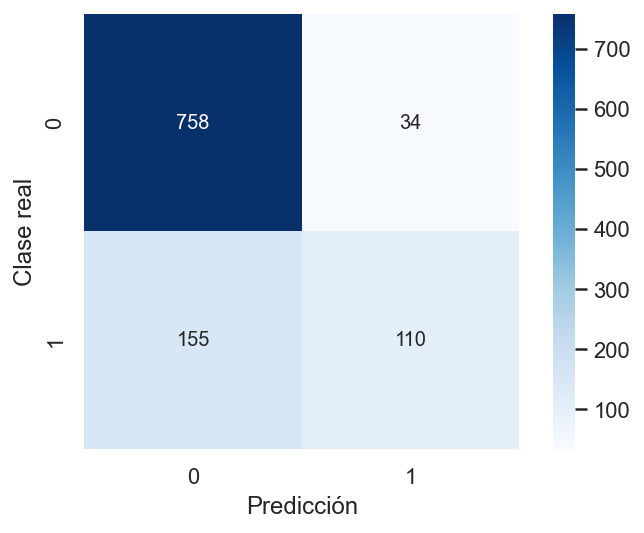

Resultados: 
	accuracy: 0.821
	recall: 0.415
	precision: 0.764
	f1_score: 0.538


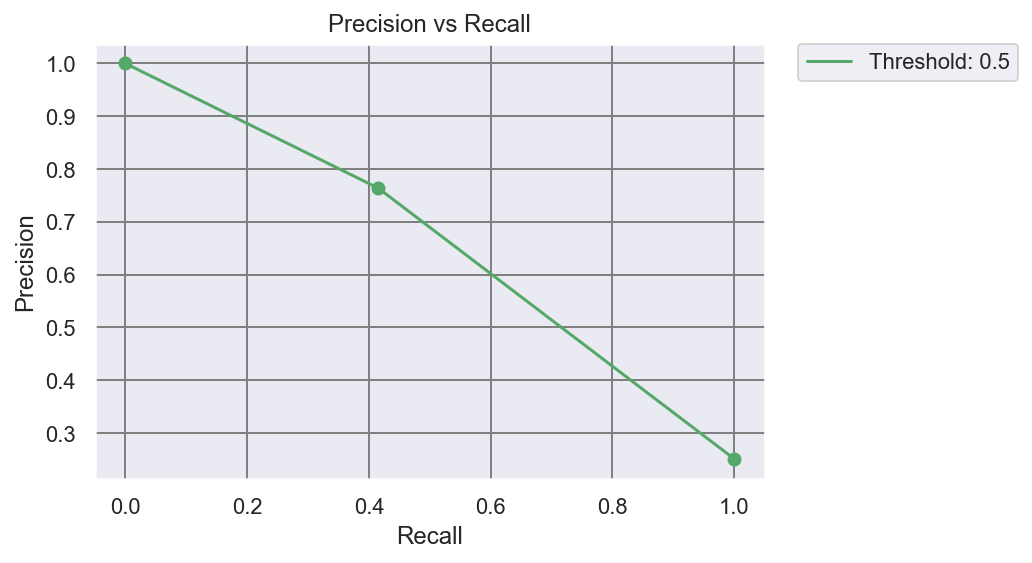

In [53]:
y_pred_new = y_prob_new >= 0.5
show_results(y_new, y_pred_new)

precision, recall, threshold = precision_recall_curve(y_new, y_pred_new)
plt.plot(recall, precision, 'g', label = 'Threshold: 0.5') 
plt.plot(recall, precision, 'og')
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 21</font>

¿Cómo aumentaríamos al precisión hasta un 0.75 (con respecto a los datos obtenidos en el ejercicio anterior, con umbral 0.5)? ¿Compensaría hacerlo?

___Respuesta:___

Para este caso la precisión supera el 75%. Sin embargo si no fuese el caso, es posible modificar el umbral, esto ocasionaría una ligera mejora en la precisión que impactaría en la exhaustividad, compensaría hacerlo si la variación de la exhaustividad no fuese pronunciada. Otra forma de mejorar la precisión sería aumentar la cantidad de muestras de entrenamiento para obtener un mejor modelo o mejorando los parámetros de entrenamiento del modelo.

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 22</font>

Construir un _Pipeline_ similar al anterior, denominado `churn_pipe_svc`, y que utilice una máquina de soporte vectorial.  Determinar la mejor configuración de los parámetros con `GridSearchCV`, utilizando como `scoring` la medida que consideréis más adecuada. Guardar el modelo resultante en `churn_pipe_svc`. Mostrar los resultados con respecto al conjunto de nuevos datos `X_new, y_new`.

Mejor score:  0.8200220628792056
Mejore configuración de parámetros:  {'clas__C': 0.1, 'clas__kernel': 'linear', 'prep__num__imputer__strategy': 'mean'}


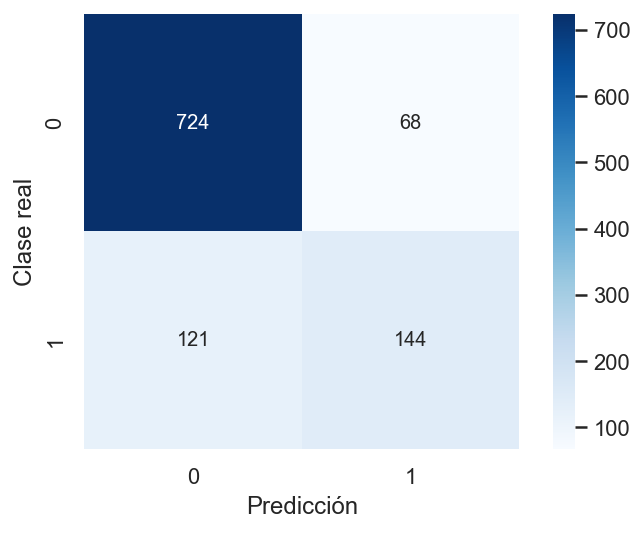

Resultados: 
	accuracy: 0.821
	recall: 0.543
	precision: 0.679
	f1_score: 0.604


In [54]:
from sklearn.svm import SVC

svm_model = SVC(probability=True);

churn_pipe_svc = Pipeline([('prep', churn_trans), ('clas', svm_model)])

parameters = {}
parameters['prep__num__imputer__strategy'] = ['mean', 'median']
parameters['clas__C'] = [10e-2, 1, 100]
parameters['clas__kernel'] = ['linear', 'rbf']

kf = KFold(n_splits=5, shuffle=True)
GS = GridSearchCV(churn_pipe_svc, parameters, cv=kf, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, shuffle=True, random_state=0)
GS.fit(X_train, y_train)

print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

churn_pipe_svc = GS.best_estimator_

churn_pipe_svc = GS.best_estimator_

y_pred_new = churn_pipe_svc.predict(X_new)
show_results(y_new, y_pred_new)

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 23</font>

Dibujar la curva _Precision/Recall_ también con respecto a los nuevos datos.

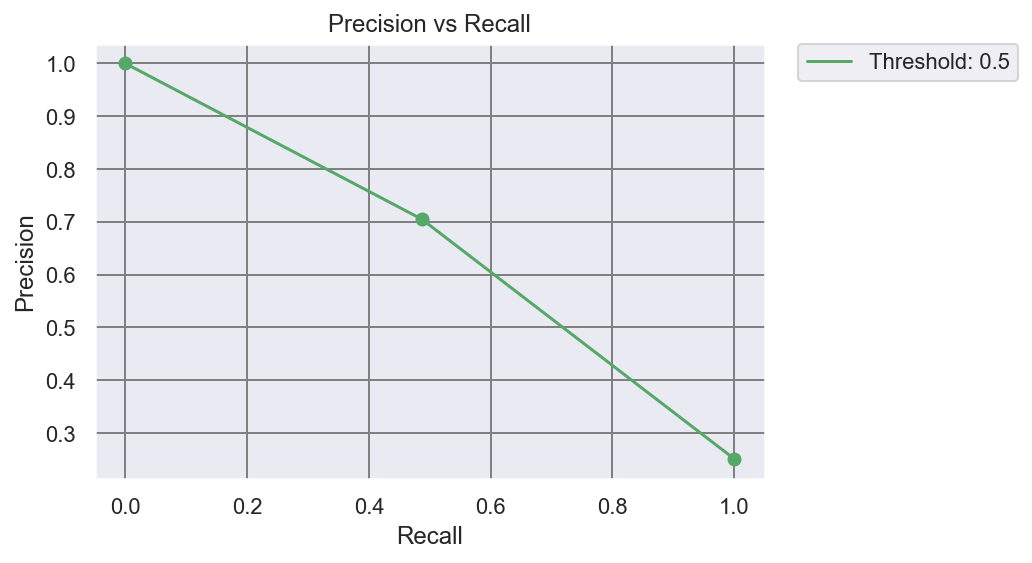

In [55]:
y_prob_new = churn_pipe_svc.predict_proba(X_new)[:,1]
y_pred_new = y_prob_new >= 0.5

precision, recall, threshold = precision_recall_curve(y_new, y_pred_new)
plt.plot(recall, precision, 'g', label = 'Threshold: 0.5') 
plt.plot(recall, precision, 'og')
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

#### <font color="#7F000E"> Comparación de los modelos </font>
<br>

Como se ha visto anteriormente, el rendimiento de cada modelo de clasificación depende del umbral a partir del cual se considere una predicción como positiva. A la hora de comparar se podría determinar el umbral más conveniente para cada uno, y después utilizar los resultados obtenidos. 

El área bajo la curva ROC (AUC) proporciona una medida del rendimiento considerando todos los umbrales posibles. Representa la probabilidad de que el modelo asigne un _score_ mayor a un modelo positivo que a un negativo, y es invariable con respecto a este factor. Por eso se utiliza para la comparación de modelos. 

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 24</font>
Dibujar la curva ROC para los tres modelos (utilizar los datos nuevos). ¿Qué clasificador es mejor?

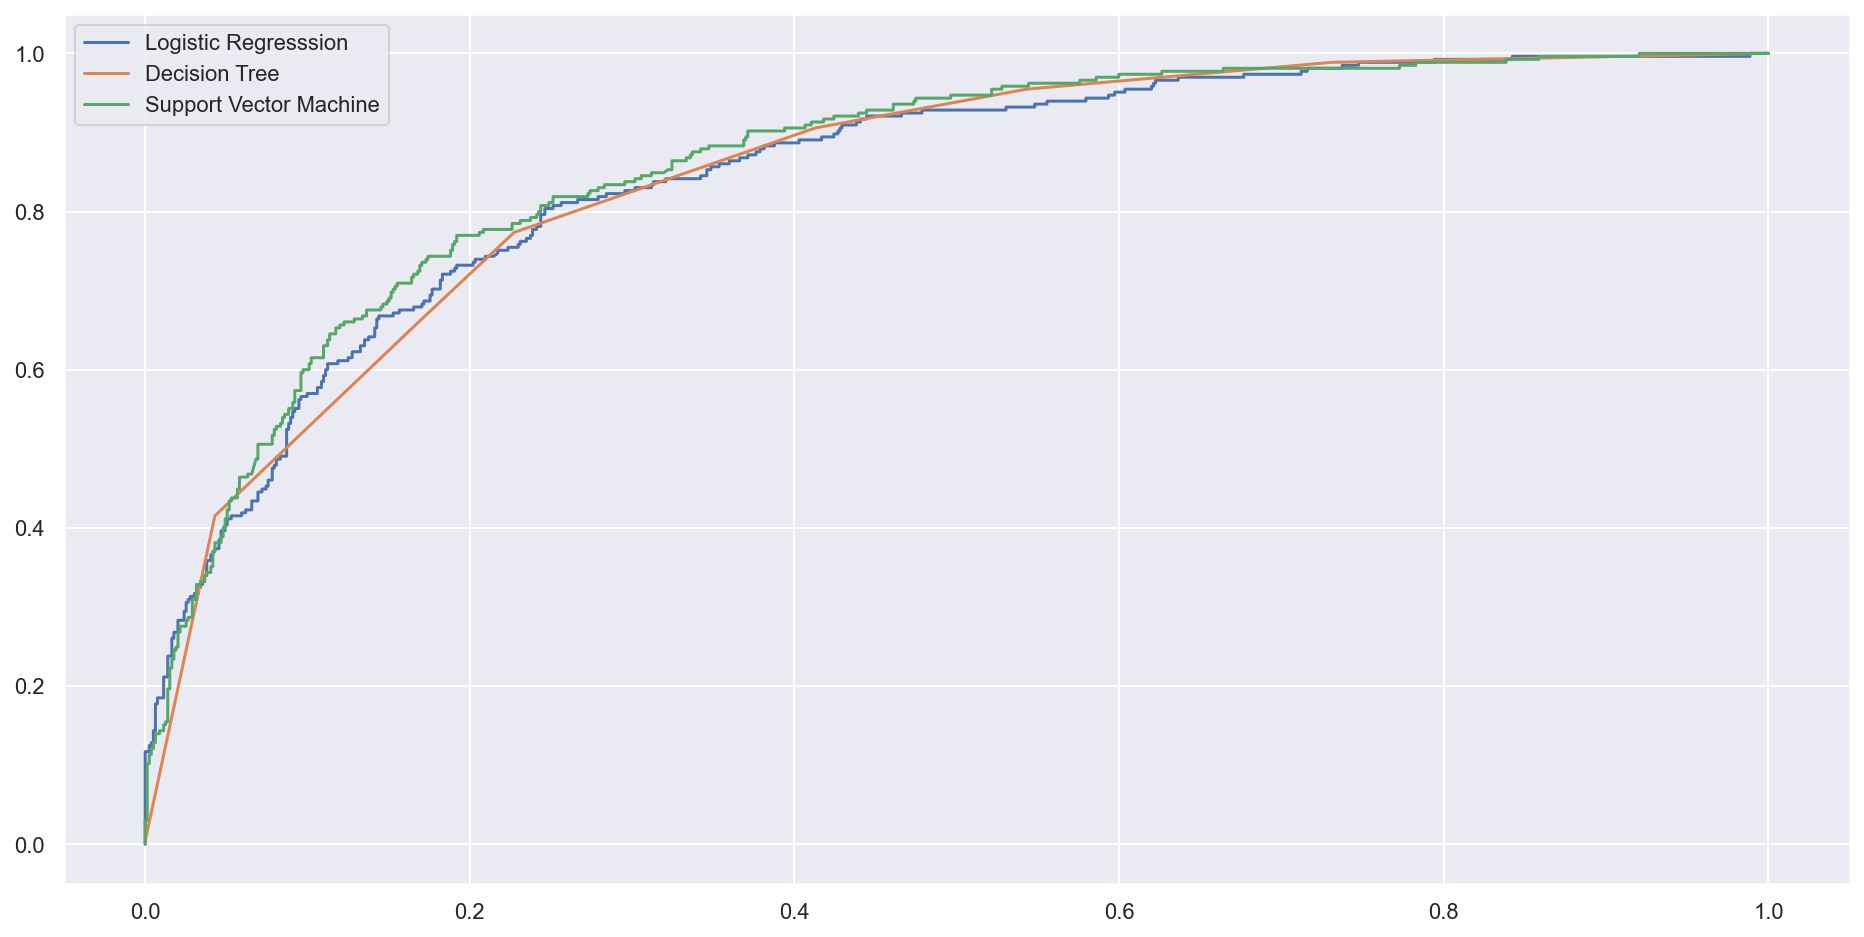

In [56]:
from sklearn.metrics import roc_curve

y_prob_logr = churn_pipe_logr.predict_proba(X_new)[:,1]
y_prob_tree = churn_pipe_tree.predict_proba(X_new)[:,1]
y_prob_svc = churn_pipe_svc.predict_proba(X_new)[:,1]

fpr_logr, tpr_logr, _ = roc_curve(y_new, y_prob_logr)
fpr_tree, tpr_tree, _ = roc_curve(y_new, y_prob_tree)
fpr_svc, tpr_svc, _ = roc_curve(y_new, y_prob_svc)

plt.figure(figsize=(16, 8))
plt.plot(fpr_logr , tpr_logr, label='Logistic Regresssion')
plt.plot(fpr_tree , tpr_tree, label='Decision Tree')
plt.plot(fpr_svc , tpr_svc, label='Support Vector Machine')
plt.legend()
plt.show()

___Respuesta:___

Al analizar las curvas ROC, las mejores son las que tienen un area bajo la curva mayor y cuya curva sea más cercana a la esquina superior izquierda. Del gráfico mostrado se puede apreciar que el modelo SVM es la mejor, seguida por Regresión logística y finalmente el Arbol de decisión, siendo estos dos últimos muy cercanos.
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 25</font>
Mostrar el AUC para cada uno de los clasificadores. ¿Se corresponde con lo esperado?

In [57]:
from sklearn.metrics import roc_auc_score
print("Regresión logística: ",roc_auc_score(y_new, y_prob_logr))
print("Árbol de decisión: ",roc_auc_score(y_new, y_prob_tree))
print("Máquina de vectores de soporte: ",roc_auc_score(y_new, y_prob_svc))

Regresión logística:  0.8468458166571375
Árbol de decisión:  0.8456856298837431
Máquina de vectores de soporte:  0.860034305317324


___Respuesta:___

Debido a que AUC significa Area bajo la curva ROC, esta métrica nos brinda el valor exacto del area. Para el ejemplo tratado AUC confirma SVM > Logistic Regression > Decision Tree.
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#7F000E"></i></font></a>
</div>

---

<a id="section2"></a>
# <font color="#7F000E"> 2. Predicción del valor potencial de un cliente (_Customer Lifetime Value_)</font>
<br>

El valor potencial de un cliente (_Customer Lifetime Value_ o _CLV_) permite determinar el beneficio que un cliente puede proporcionar a lo largo de un periodo de tiempo. En muchos casos, este valor es función de otros, por lo que es posible elaborar modelos predictivos para llevar a cabo una estimación. En este ejercicio se parte de un conjunto de datos denominado `Marketing-Customer-Value-Analysis.csv`, obtenido también del sitio de [IBM analytics](https://www.ibm.com/analytics) con datos sobre CLV. 
<br>


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> A diferencia de la tarea anterior, en este caso el preprocesamiento se hará de modo más simple (no es necesario hacer más), y el trabajo se centrará en el desarrollo y análisis de un modelo de regresión.
</div>

In [58]:
df_clv = pd.read_csv('data/clv/Marketing-Customer-Value-Analysis.csv', index_col=0)

print("Tamaño del conjunto de datos:  %d" % df_clv.shape[0])
print("Número de variables: %d" % df_clv.shape[1])
if df_clv.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')
    
# Visualiza las primeras instancias
df_clv.head()

Tamaño del conjunto de datos:  9134
Número de variables: 23
El índice es único.


,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
Customer,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


Los nombres de las columnas numéricas del _DataFrame_ se almacenan en una lista denominada `num_df_columns`, y el resto en otra denominada `dis_df_columns`. 

In [59]:
dis_df_columns = df_clv.select_dtypes(exclude=np.number).columns.to_list()
num_df_columns = df_clv.select_dtypes(include=np.number).columns.to_list()

print('Discretas: ',dis_df_columns)
print('\nNuméricas: ',num_df_columns)

Discretas:  ['State', 'Response', 'Coverage', 'Education', 'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']

Numéricas:  ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']


En primer lugar, se procederá con las columnas que contienen valores discretos. Igual que anteriormente, conviene ver el número de valores que toma cada una para comprobar que, efectivamente, la representación corresponde a los datos. A continuación, se obtiene el número de valores para cada una de las variables discretas y se almacena en una lista denominada `num_values_dis_df_col`. Cada elemento de la lista ha de ser una tupla con el nombre de la columna y el número de variables. 

In [60]:
num_values_dis_df_col = list(map(lambda col: (col,len(df_clv[col].value_counts())), dis_df_columns))
num_values_dis_df_col

[('State', 5),
 ('Response', 2),
 ('Coverage', 3),
 ('Education', 5),
 ('Effective To Date', 59),
 ('EmploymentStatus', 5),
 ('Gender', 2),
 ('Location Code', 3),
 ('Marital Status', 3),
 ('Policy Type', 3),
 ('Policy', 9),
 ('Renew Offer Type', 4),
 ('Sales Channel', 4),
 ('Vehicle Class', 6),
 ('Vehicle Size', 3)]

La columna `Effective To Date` contiene datos relativos a fechas. Estos no pueden manejarse directamente en `scikit-learn`. Sin embargo, es posible convertirlos a enteros que representen días transcurridos desde una fecha determinada. Por ejemplo, la más temprana que aparezca en la columna.

En la siguiente celda, se convierte la columna `Effective To Date` a formato `DateTime`. Posteriormente se calcula la diferencia con la primera fecha y se convierte a entera (con `TimeDelta.dt.days`). Por último, se elimina la columna de `num_df_columns` y se añade a `dis_df_columns`.

In [61]:
df_clv['Effective To Date'] = pd.to_datetime(df_clv['Effective To Date'])

min_date = min(df_clv['Effective To Date'])
df_clv['Effective To Date'] = df_clv['Effective To Date'].apply(lambda date: date - min_date)
df_clv['Effective To Date'] = df_clv['Effective To Date'].dt.days

num_df_columns.append('Effective To Date')
dis_df_columns.remove('Effective To Date')

Debido a que solamente dos variables son binarias, y con el ánimo de simplificar, se tratarán todas como categóricas. A continuación se explorarán las variables numéricas para encontrar outliers. 

In [62]:
df_clv[num_df_columns].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Effective To Date
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,28.837749
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,16.942769
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000
1%,2230.433731,0.000000,61.000000,0.000000,1.000000,0.000000,1.000000,10.402835,0.000000
5%,2475.109047,0.000000,62.000000,1.000000,4.000000,0.000000,1.000000,52.261227,2.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,14.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,28.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,43.000000
95%,22064.361267,90374.350000,163.350000,33.000000,93.000000,3.000000,8.000000,960.115399,56.000000


Parece que solamente la variable de clase, `Customer Lifetime Value` podría presentar _outliers_. Para comprobar si esos valores extremos corresponden a un error o son parte del "fenómeno" que representa la variable, puede dibujarse la distribución de la misma. 

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 26</font> 
Dibujar la distribución de la variable de clase con una gráfica `sns.distplot()`/`sns.kdeplot()`.

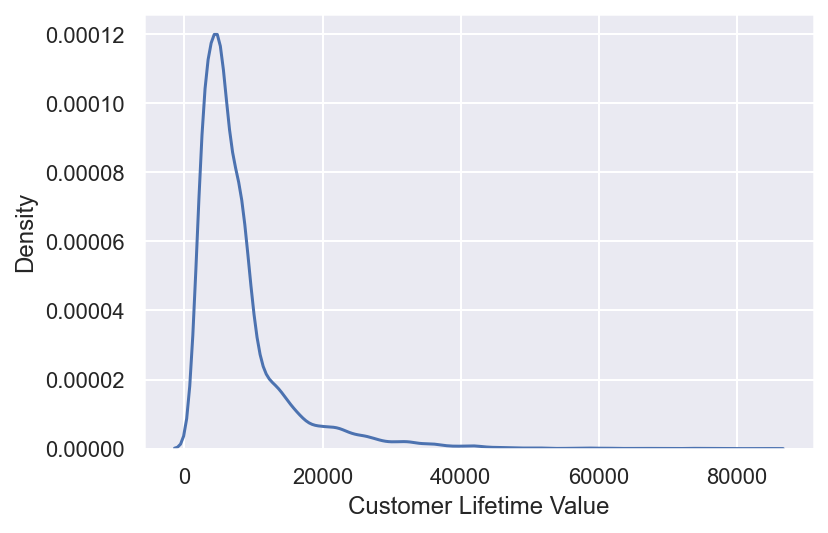

In [63]:
sns.kdeplot(df_clv['Customer Lifetime Value'])
plt.show()

Se aprecia que los valores extremos no son anomalías o errores. Sin embargo, la diferencia con la mayoría de valores es tan grande, y su proporción en la base de datos tan reducida, que conviene no incluirlos en el modelo. Por tanto, se van a considerar los clientes con un $CLV < 22000$, es decir, aproximadamente el 95%.

Una vez determinados los tipos de las características, y filtrados los casos extremos, se crearán los conjuntos de entrenamiento y test. 

In [64]:
from sklearn.model_selection import train_test_split

num_df_columns.remove('Customer Lifetime Value')
X = df_clv[df_clv['Customer Lifetime Value']<22000].drop('Customer Lifetime Value', 1)
y = df_clv.loc[df_clv['Customer Lifetime Value']<22000,'Customer Lifetime Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Para llevar a cabo la transformación se utilizará el mismo procedimiento que en la tarea anterior(los _Pipelines_ `num_transformer` y  `cat_transformer`).

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 27</font>

Crear un objeto `ColumnTransformer` que aplique el _Pipeline_ de transformación `num_transformer` a las columnas en `num_df_colums`, el _Pipeline_ `cat_transformer` a las columnas en `dis_df_columns`. Denominarlo `clf_trans`.



In [65]:
clv_trans = ColumnTransformer( transformers=[('num', num_transformer, num_df_columns),
            ('cat', cat_transformer, dis_df_columns)])

Con respecto a la predicción, se utilizará un modelo de regresión lineal.

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 28</font>

Crear un objeto _Pipeline_, denominado `churn_pipe_linr` a partir de `clv_trans` y un modelo de regresión, que estará almacenado en la variable `linr_model`. Entrenarlo con los datos de entrenamiento. Imprimir el _score_ del modelo para entrenamiento y test. ¿Qué representa este _score_? ¿Qué valoración podría hacerse del mismo?

In [66]:
from sklearn.linear_model import LinearRegression

linr_model = LinearRegression();

churn_pipe_linr =   Pipeline(steps=[('clv_trans', clv_trans), ('linr_model', linr_model)])
churn_pipe_linr.fit(X_train, y_train);


print('Score del modelo para entrenamiento:', churn_pipe_linr.score(X_train, y_train))
print('Score del modelo para test:', churn_pipe_linr.score(X_test, y_test))

Score del modelo para entrenamiento: 0.20360261335903462
Score del modelo para test: 0.20086629447870574


___Respuesta:___

El score de modelo es una medida de que tan bien se ajusta el modelo a los datos, en el caso del entrenamiento nos indica que tan bien se ajusta a los datos de entrenamiento y en el caso del modelo de test mide que tan bien el modelo generaliza los datos nuevos (de prueba).

Lo ideal es que tanto el score de modelo para entrenamiento como para test sea similare, como este caso. Caso contrario, si el score de entrenamiento supera con margen el de test, indica que el modelo presenta un sobreajuste. Además, si el score de test es mayor que el de entrenamiento puede indicar que el modelo está subajustado a los datos de entrenamiento.
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

La función `show_errors` muestra el error absoluto medio con respecto a los datos de entrenamiento y test, y también una medida del error relativo absoluto medio. Mostrar los errores relativos al modelo `churn_pipe_linr`. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> El error relativo absoluto medio se calculará aquí como:

$$
error_{rel} = \frac{\sum_{i=1}^m \frac{|\hat{y_i} - y_i|}{y_i}}{m}.
$$

<br>

Esta última medida es arbitraria, pero permite hacernos una idea de la magnitud del error con respecto al _CLV_ de cada usuario.
</div>

In [67]:
from sklearn.metrics import mean_absolute_error

def show_errors(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmae = np.sum(np.abs(y-y_pred)/y)/len(y)    
    print(f'\tEl error absoluto medio es: {mae:.2f}')
    print(f'\tEl error absoluto relativo medio es: {rmae:.2f}')

print('Entrenamiento')
y_pred = churn_pipe_linr.predict(X_train)
show_errors(y_train, y_pred)

print('Test')
y_pred = churn_pipe_linr.predict(X_test)
show_errors(y_test, y_pred)

Entrenamiento
	El error absoluto medio es: 2627.97
	El error absoluto relativo medio es: 0.46
Test
	El error absoluto medio es: 2573.69
	El error absoluto relativo medio es: 0.46


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---


<a id="section21"></a>
## <font color="#7F000E"> 2.1 Construcción de un árbol de regresión </font>
<br>



Puede apreciarse que, tal y como era de esperar, el error es muy alto. Por tanto se va a definir el procedimiento anterior, pero con un árbol de regresión.


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 29</font>

Crear un _Pipeline_ denominado `churn_pipe_dtr`, similar al anterior, pero en el que el modelo predictivo sea un árbol de regresión. Entrenarlo e imprimir su _score_ para entrenamiento y test. 



In [68]:
from sklearn.tree import DecisionTreeRegressor


dtr_model = DecisionTreeRegressor(random_state=0);

churn_pipe_dtr = Pipeline(steps=[('clv_trans', clv_trans), ('dtr_model',dtr_model)])

churn_pipe_dtr.fit(X_train, y_train);

print("Entrenamiento:", churn_pipe_dtr.score(X_train,y_train))
print("Test:", churn_pipe_dtr.score(X_test,y_test))

Entrenamiento: 1.0
Test: 0.702649059852204


Error absoluto medio (también el relativo) para entrenamiento y test: 

In [69]:
print('Entrenamiento')
y_pred = churn_pipe_dtr.predict(X_train)
show_errors(y_train, y_pred)

print('Test')
y_pred = churn_pipe_dtr.predict(X_test)
show_errors(y_test, y_pred)

Entrenamiento
	El error absoluto medio es: 0.00
	El error absoluto relativo medio es: 0.00
Test
	El error absoluto medio es: 692.63
	El error absoluto relativo medio es: 0.07


Por otra parte, el tamaño del árbol obtenido es:

In [70]:
print(f"Profundidad: {churn_pipe_dtr.named_steps['dtr_model'].get_depth()}")
print(f"Número de hojas: {churn_pipe_dtr.named_steps['dtr_model'].get_n_leaves()}")

Profundidad: 30
Número de hojas: 5278


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 30</font> 

¿Qué conclusión se puede sacar de los resultados?

___Respuesta:___

En primer lugar, el score de entrenamiento al ser mayor que el score de test, indica un posible sobre ajuste. Además el score de 1.0 sugiere que el modelo estaría memorizando en lugar de aprendiendo patrones para luego generalizarlos.
En segundo lugar, el error absoluto medio entre los datos de entrenamiento y test tienen demasiada diferencia, lo que da más indicios de un sobreajuste.
Finalmente, la profundidad de 30 y el número de hojas 5278 muestran un arbol de bastante profundidad motivo por el cual explica el ajuste extremo a los datos de entrenamiento y sobreajuste.
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

En el caso anterior, no se había limitado la profundidad, por lo que el tamaño del árbol resultante es muy grande.
 
#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 31</font> 


A continuación se determinará, mediante `GridSearchCV` la profundidad adecuada. Crear un _Pipeline_ similar anterior, denominado `churn_pipe_dtr_p`. Utilizar validación cruzada de 5 particiones, y `neg_mean_absolute_error` como medida de _scoring_.  Almacenar el _Pipeline_ resultante en `churn_pipe_dtr_p`. Por último, imprimir los _score_ ($R^2$) del modelo obtenido.

In [71]:
parameters = {}
parameters['clas__max_depth'] = [None, 2, 5, 10, 15, 20]

dtr_p_model = DecisionTreeRegressor(random_state=0);

churn_pipe_dtr_p = Pipeline(steps=[('prep', clv_trans),
                                   ('clas', dtr_p_model)])


kf = KFold(n_splits=5, shuffle=True)
GS_p = GridSearchCV(churn_pipe_dtr_p, parameters, cv=kf, scoring='neg_mean_absolute_error')
GS_p.fit(X_train, y_train)

churn_pipe_dtr_p = GS_p.best_estimator_

print("\nEntrenamiento:", churn_pipe_dtr_p.score(X_train, y_train))
print("Test:", churn_pipe_dtr_p.score(X_test, y_test))


Entrenamiento: 0.8893117529464726
Test: 0.7836483671865917


Por otra parte, el tamaño del árbol obtenido es ahora:

In [72]:
print(f"Profundidad: {churn_pipe_dtr_p.named_steps['clas'].get_depth()}")
print(f"Número de hojas: {churn_pipe_dtr_p.named_steps['clas'].get_n_leaves()}")

Profundidad: 10
Número de hojas: 695


Error absoluto medio (también el relativo) para entrenamiento y test: 

In [73]:
print('Entrenamiento')
y_pred = churn_pipe_dtr_p.predict(X_train)
show_errors(y_train, y_pred)

print('Test')
y_pred = churn_pipe_dtr_p.predict(X_test)
show_errors(y_test, y_pred)

Entrenamiento
	El error absoluto medio es: 466.04
	El error absoluto relativo medio es: 0.05
Test
	El error absoluto medio es: 673.70
	El error absoluto relativo medio es: 0.07


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 32</font>


Compara y analiza los resultados obtenidos con respecto a los obtenidos anteriormente.

___Respuesta:___

Respecto a los valores anteriores el score de entrenamiento bajó de 1.0 -> 0.889, lo que indica que el modelo no está sobre ajustando como si lo hacía anteriormente, esto unido al score de prueba que ha subido desde un 0.70 -> 0.78 indica que el modelo puede generalizar mejor los nuevos datos. Además, el error absoluto y medio ha aumentado lo que indica que el modelo no está ajustando tanto como el modelo anterior. Finalmente, la profundidad del arbol bajo de 30 -> 10 y su numero de hojas de 5278 -> 695, al ser un árbol menos complejo esta ajustando menos a los datos de entrenamiento y generalizando de forma más efectiva a nuevos valores.

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section3"></a>
# <font color="#7F000E"> 3. Segmentación de clientes</font>
<br>

En el manejo de la relación con el cliente (_CRM_) es necesario tener en cuenta varios factores. Por un lado, cada cliente tiene unas peculiaridades, y la relación con él se ha de definir de manera concreta. Por otro lado, el número de clientes es elevado, y no es posible personalizar completamente el modo en que se va a llevar la relación. Debido a esto, una de las tareas relacionadas con ciencia de datos que son más comunes en _CRM_ es la segmentación, cuyo objetivo es crear grupos de clientes con el mismo perfil.
<br>

Para abordar la segmentación se utilizan algoritmos de _clustering_. Una de las particularidades de estos algoritmos es que pierden utilidad cuando se trata con un número muy elevado de variables. Por eso suelen utilizarse con conjuntos reducidos. Un tipo de análisis frecuente en este sentido es el RFM (_Recency_, _Frequency_, _Monetary value_), en el que se segmenta a los clientes en función de cuando hicieron su última transacción, con qué frecuencia han hecho transacciones, y cuanto dinero han gastado en total. 
<br>

En esta tarea se partirá de un conjunto de datos de venta online obtenido en el repositorio de conjuntos de datos de la [UCI](https://archive.ics.uci.edu/ml/datasets/online+retail) (un subconjunto de éste). Tras una serie de transformaciones, se utilizará `KMeans` para caracterizar los clusters.

A continuación, se lee el conjunto de datos `data/segmentation/online12M.csv` y se guarda en el `DataFrame` `df_ol`. La columna `InvoiceDate` se trata como marca de tiempo. 

In [74]:
# Carga los datos 
df_ol = pd.read_csv('data/segmentation/online12M.csv', index_col=0, parse_dates=['InvoiceDate']);

print("Tamaño del conjunto de datos:  %d" % df_ol.shape[0])
print("Número de variables: %d" % df_ol.shape[1])
if df_ol.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')
    
# Visualiza las primeras instancias
df_ol.head()

Tamaño del conjunto de datos:  68176
Número de variables: 8
El índice es único.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


Una de las columnas que vamos a utilizar (_Monetary Value_) hace referencia al precio total gastado por cliente. La columna  `Total` almacena el resultado de multiplicar el precio por unidad de cada compra (`UnitPrice`) por la cantidad de unidades (`Quantity`).

In [75]:
df_ol['Total'] = df_ol['Quantity']*df_ol['UnitPrice']
df_ol.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom,12.60
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom,1.45
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom,22.50
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom,2.10
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom,17.85


A continuación se crearán las columnas `Recency, Frequency` y `MonetaryValue`. Para ello, se han de agrupar los datos por cliente, y después hacer una agregación a partir del grupo sobre las columnas:
* `InvoiceDat`. Hay que crear un día de referencia (el posterior al último de la lista) y restarle el último día (`max`) en que compró cada cliente. El resultado, un `TimeDelta` se devuelve en días (`.days`).
* `InvoiceNo`. Se cuenta el número de facturas.
* `MonitaryValue`. Se suma, para cada grupo, la columna `Total`.

A continuación se obtiene la información según el procedimiento descrito, y se almacena en el `DataFrame` `df_rfm`.

In [76]:
import datetime
dia_ref = max(df_ol['InvoiceDate']) + datetime.timedelta(days=1)

In [77]:
df_rfm = df_ol.groupby(['CustomerID']).agg({ 
    'InvoiceDate': lambda x: (dia_ref - x.max()).days, 
    'InvoiceNo': 'count',
    'Total': 'sum'})

df_rfm.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total': 'MonetaryValue'}, inplace=True)

df_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 33</font>

Dibujar la distribución de cada una de las variables mediante `sns.displot()` en una figura de $1 \times 3$ gráficas.

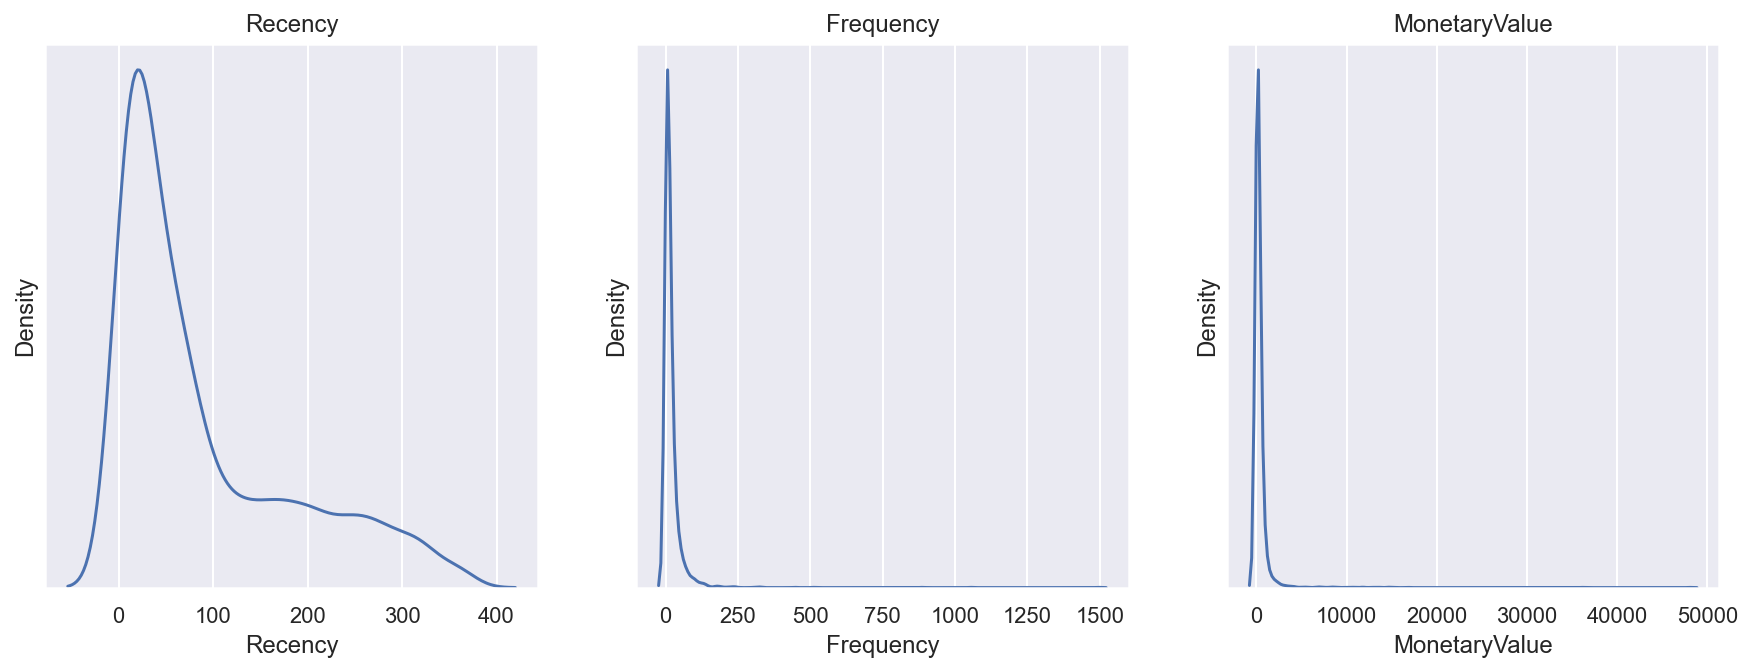

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
features = ['Recency', 'Frequency','MonetaryValue']
for col, ax in enumerate(axs.flatten()):
    col_name = features[col]
    #sns.displot(data=df_rfm, x=col_name, kind='kde', ax=ax)
    sns.kdeplot(data = df_rfm, x = col_name, ax = ax)
    ax.set_title(col_name); 
    ax.set_yticks([])

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> __Nota:__. 
En el gráfico anterior la función displot, no es compatible con subplots y al imprimir lo hace en una 3 nuevas figures, por ello, para mantener la forma del diagrama se comentó la linea de sns.displot y se utilizó kdeplot.
</div>





Puede apreciarse que las distribuciones están muy sesgadas. Esto supone un problema para el algoritmo `KMeans` que construye los clusters por distancias. Una forma de solucionarlo es utilizar el logaritmo de las variables.  El resultado se almacena en el `DataFrame` `dt_rfm_log`.

In [79]:
df_rfm_log = np.log(df_rfm)

La diferencia de escalas también supone un problema, ya que intrínsecamente, hace que el cálculo de las distancias de más importancia a las variables con mayor rango. Debido a esto, es necesario estandarizar los datos. El resultado se almacena en el *DataFrame* `df_rfm_norm`.

In [80]:
df_rfm_norm = df_rfm_log - df_rfm_log.mean()
df_rfm_norm = df_rfm_norm / df_rfm_log.std()
df_rfm_norm.describe()

,Recency,Frequency,MonetaryValue
count,3.643000e+03,3.643000e+03,3.643000e+03
mean,-7.604344e-15,-1.081413e-14,-1.258779e-14
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.814131e+00,-1.794485e+00,-4.092988e+00
25%,-6.373074e-01,-6.490904e-01,-6.578277e-01
50%,9.266763e-02,2.092218e-02,-1.489601e-02
75%,8.339256e-01,7.209827e-01,6.692029e-01
max,1.547663e+00,4.246243e+00,4.458854e+00


Una vez preparados los datos, se puede llevar a cabo el procedimiento de agrupación. El algoritmo `KMeans` toma como parametro más importante `k` que corresponde al número de clusters. Cuando no se tiene información a priori, se dibuja la curva del coste en función de `k`. Debido a que se busca un compromiso entre un bajo coste, y un número reducido de clusters,  se toma aquel valor de `k ` a partir del cual el descenso es menor. Este método se conoce como _método del codo_.

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 34</font>

Ejecutar `KMeans` para valores del 1 al 15 sobre el conjunto de datos `df_rfm_norm`. Almacenando el coste resultante (`KMeans.inertia_`) para cada valor de `k` en el diccionario `cost`.

In [81]:
from sklearn.cluster import KMeans

cost = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_rfm_norm)
    cost[k] = kmeans.inertia_

 #### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 35</font> 
 
 Dibujar la función de coste (utilizar `cost.keys()` y `cost.values()`).

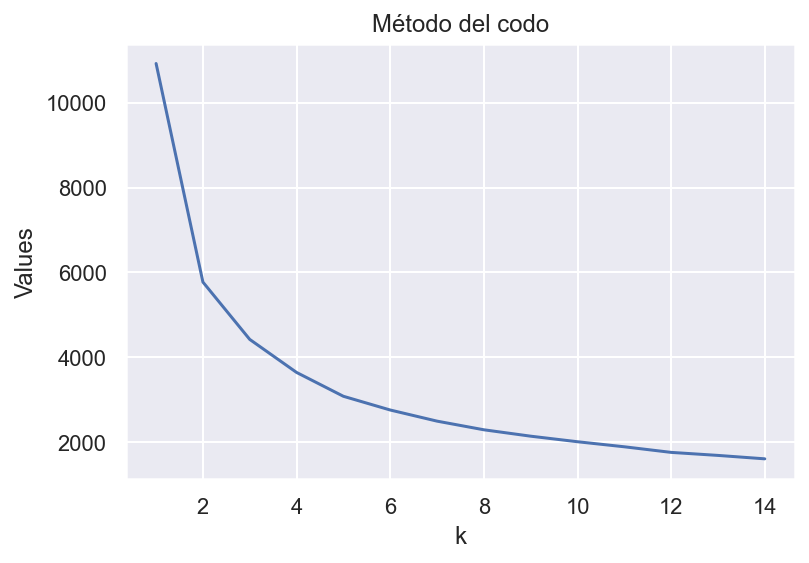

In [82]:
#
plt.plot(list(cost.keys()), list(cost.values()))
plt.title('Método del codo')
plt.xlabel('k')
plt.ylabel('Values')
plt.show()
# 

Parece que a partir de $k=4$ el descenso es menor. 

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 36</font> 

Realizar el agrupamiento con `k=4`.

In [83]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(df_rfm_norm)
labels = kmeans.predict(df_rfm_norm)

Con el fin de analizar cada grupo, se trabajará con los datos de `df_rfm` (podría trabajarse incluso con el conjunto inicial si fuese necesario). A continuación, se añade a cada entrada de `df_rfm `, una columna denominada `Group` con la etiqueta correspondiente al cluster (`KMeans.labels_`).

In [84]:
df_rfm = df_rfm.assign(Group = kmeans.labels_)
df_rfm.head()

,Recency,Frequency,MonetaryValue,Group
CustomerID,,,,
12747,3,25,948.70,3
12748,1,888,7046.16,3
12749,4,37,813.45,3
12820,4,17,268.02,3
12822,71,9,146.15,0


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 37</font>

Agregar la media por grupo para cada una de las columnas de `df_rfm` (excepto `Group`).

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> Esto nos da los centroides, pero con respecto al conjunto original. `kmeans.cluster_centers_` nos daría esa información, pero con respecto al logaritmo de los datos normalizado. Lo que no es representativo de cara a describir los grupos.
</div>

In [85]:
df_rfm.groupby('Group').mean()

,Recency,Frequency,MonetaryValue
Group,,,
0,129.321429,11.803114,231.973251
1,19.469974,10.355091,145.698839
2,165.328421,2.610526,44.198337
3,19.475449,53.742515,1129.977401


Un modo sencillo de visualizar los datos consiste dividir los valores medios de cada grupo por las medias de cada columna para el total de la información. Esto devolvería la importancia relativa de cada variable en cada cluster.  

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 38</font>
  Llevar a cabo esta operación y almacenar el resultado en `relative_imp`. Restar 1 al resultado para que un valor 0 corresponda con la media de cada columna (no hay diferencia entre el grupo y el total).

In [86]:
cluster_avg = df_rfm.groupby('Group').mean()
all_avg =  df_rfm.mean()
relative_imp =  cluster_avg / all_avg - 1


#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 39</font>  

Dibujar un mapa de calor con los datos de `relative_imp`.

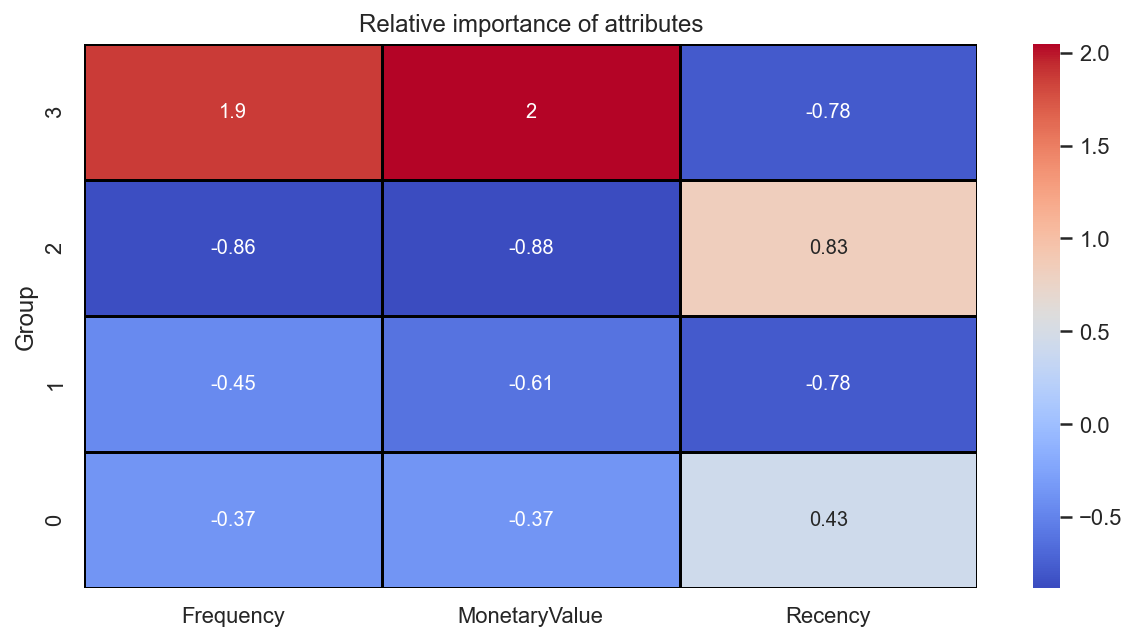

In [87]:
plt.figure(figsize=(10, 5))
plt.title('Relative importance of attributes')


relative_imp_no_group = relative_imp.drop('Group', axis=1)
gca = pd.DataFrame(relative_imp_no_group)
sns.heatmap(gca, cmap='coolwarm', annot = True, linewidth = 1.5, linecolor = 'black')

plt.gca().set_ylim(0,4);

#### <font color="#7F000E"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 40</font>  

¿Qué caracteriza, por ejemplo, a los clientes del grupo 3? ¿Y a los del grupo 1? 

___Respuesta:___

El mapa de calor muestra la importancia relativa de cada variable en cada grupo. El grupo 3 tiene la mayor importancia para la frecuencia y el valor monetario, mientras que el grupo 1 tiene la mayor importancia para la recencia. En otras palabras, los clientes del grupo 3 son los que compran con más frecuencia y gastan más dinero, mientras que los clientes del grupo 1 son los que han comprado más recientemente.
<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#00586D"></i> </font></div>